# BI8040 - notebook project - Eirini & Vasundra

## Model of interest: Mammalian cell cycle
Based on the following publication: [Logical model specification aided by model-checking techniques: application to the mammalian cell cycle regulation](https://doi.org/10.1093/bioinformatics/btw457)

First, import the necessary tools and load the model.
The model has been updated with two output nodes to better represent results.

Add the "map" we did manually

In [1]:
import ginsim 
import biolqm
import maboss
import pypint
from colomoto_jupyter import tabulate
from colomoto.temporal_logics import *
from itertools import combinations
from functools import reduce

import sys
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pandas import DataFrame

This notebook has been executed using the docker image `colomoto/colomoto-docker:2018-08-17`

You are using Pint version 2018-07-10 and pypint 1.4.2

In [2]:
lrg = ginsim.load("http://ginsim.org/sites/default/files/Traynard_MultiLevel_MamCC_Apr2016.zginml")
lrg_outputs = ginsim.load("./model_outputs.zginml")

Downloading 'http://ginsim.org/sites/default/files/Traynard_MultiLevel_MamCC_Apr2016.zginml'

In [ ]:
ginsim.show(lrg)

### Identification of attractors (asynchronous) using BIOLQM

1) Wild-type model

Trap space analysis to find the attractors of the model (1 cycle + 2 stable states)

In [3]:
lqm = ginsim.to_biolqm(lrg)

'''Compute trap space analysis'''
traps = biolqm.trapspace(lqm)
tabulate(traps)

|    |   CycD |   Rb_b1 |   Rb_b2 |   E2F |   CycE |   CycA |   CycB |   p27_b1 |   p27_b2 |   Cdc20 |   Cdh1 |   UbcH10 |   Skp2 |
|---:|-------:|--------:|--------:|------:|-------:|-------:|-------:|---------:|---------:|--------:|-------:|---------:|-------:|
|  0 |      1 |     255 |       0 |   255 |    255 |    255 |    255 |      255 |        0 |     255 |    255 |      255 |      1 |
|  1 |      0 |       1 |       1 |     0 |      0 |      1 |      0 |        1 |        1 |       0 |      1 |        0 |      0 |
|  2 |      0 |       1 |       1 |     0 |      0 |      0 |      0 |        1 |        1 |       0 |      1 |        0 |      0 |

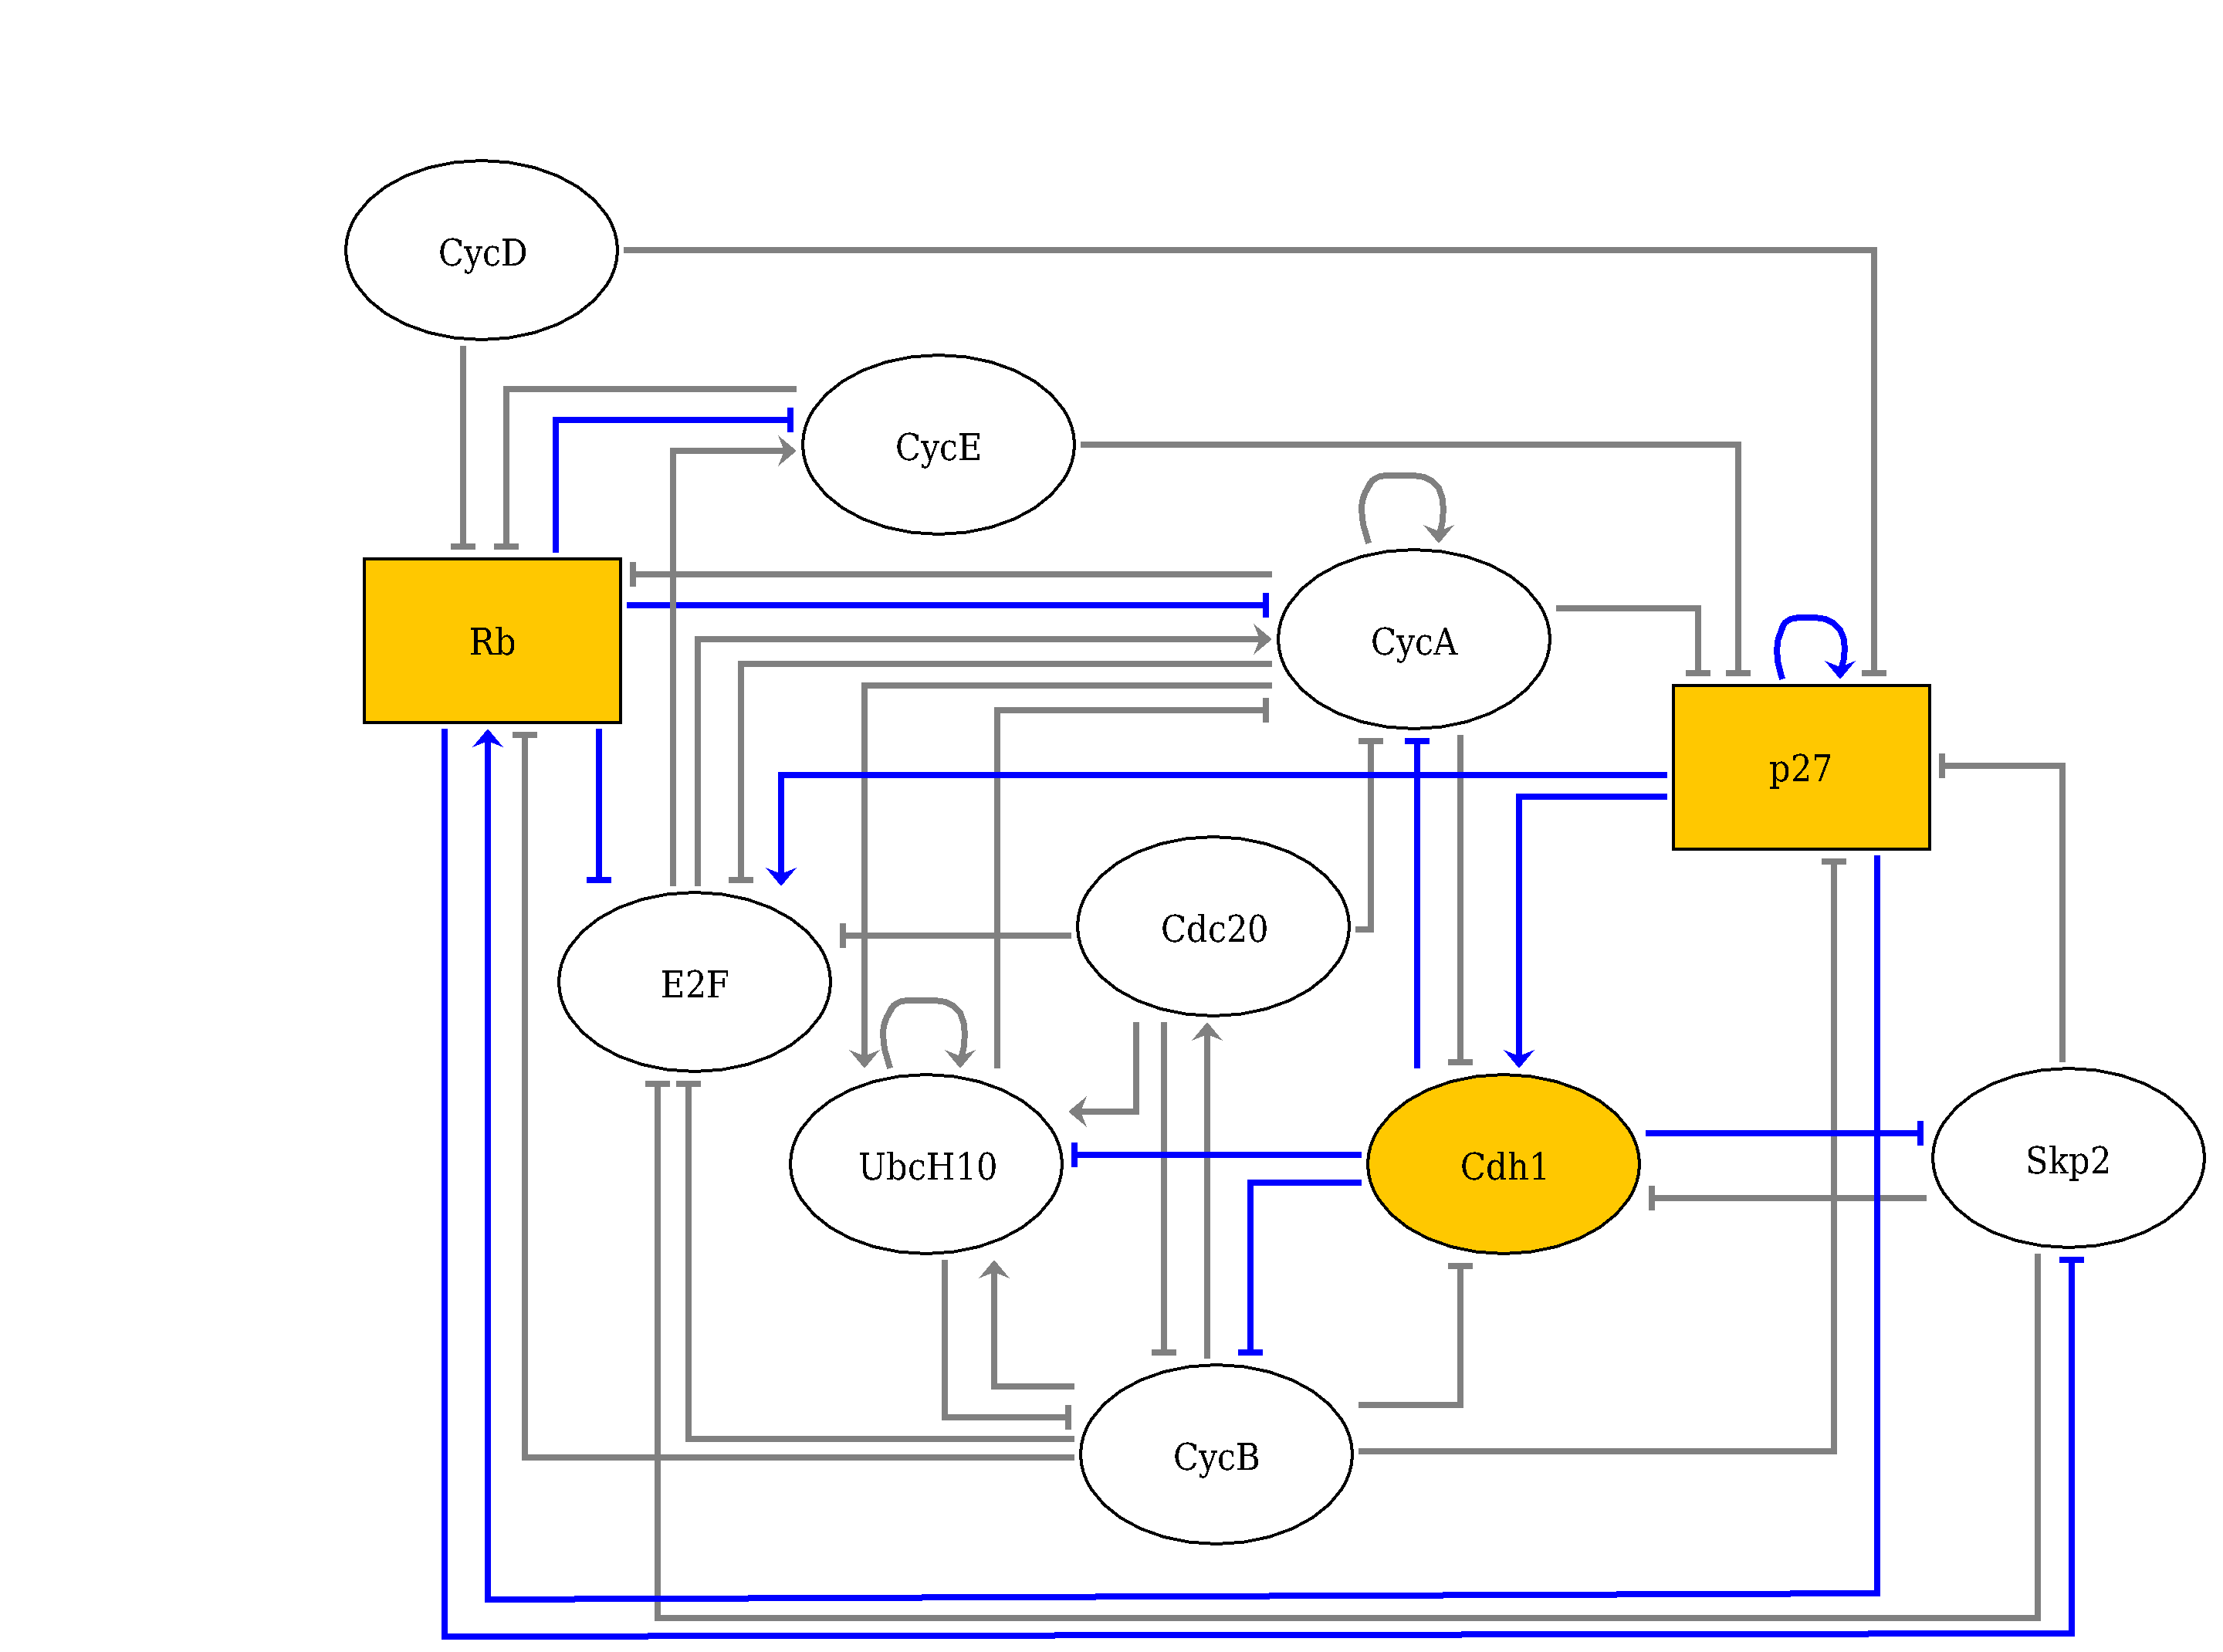

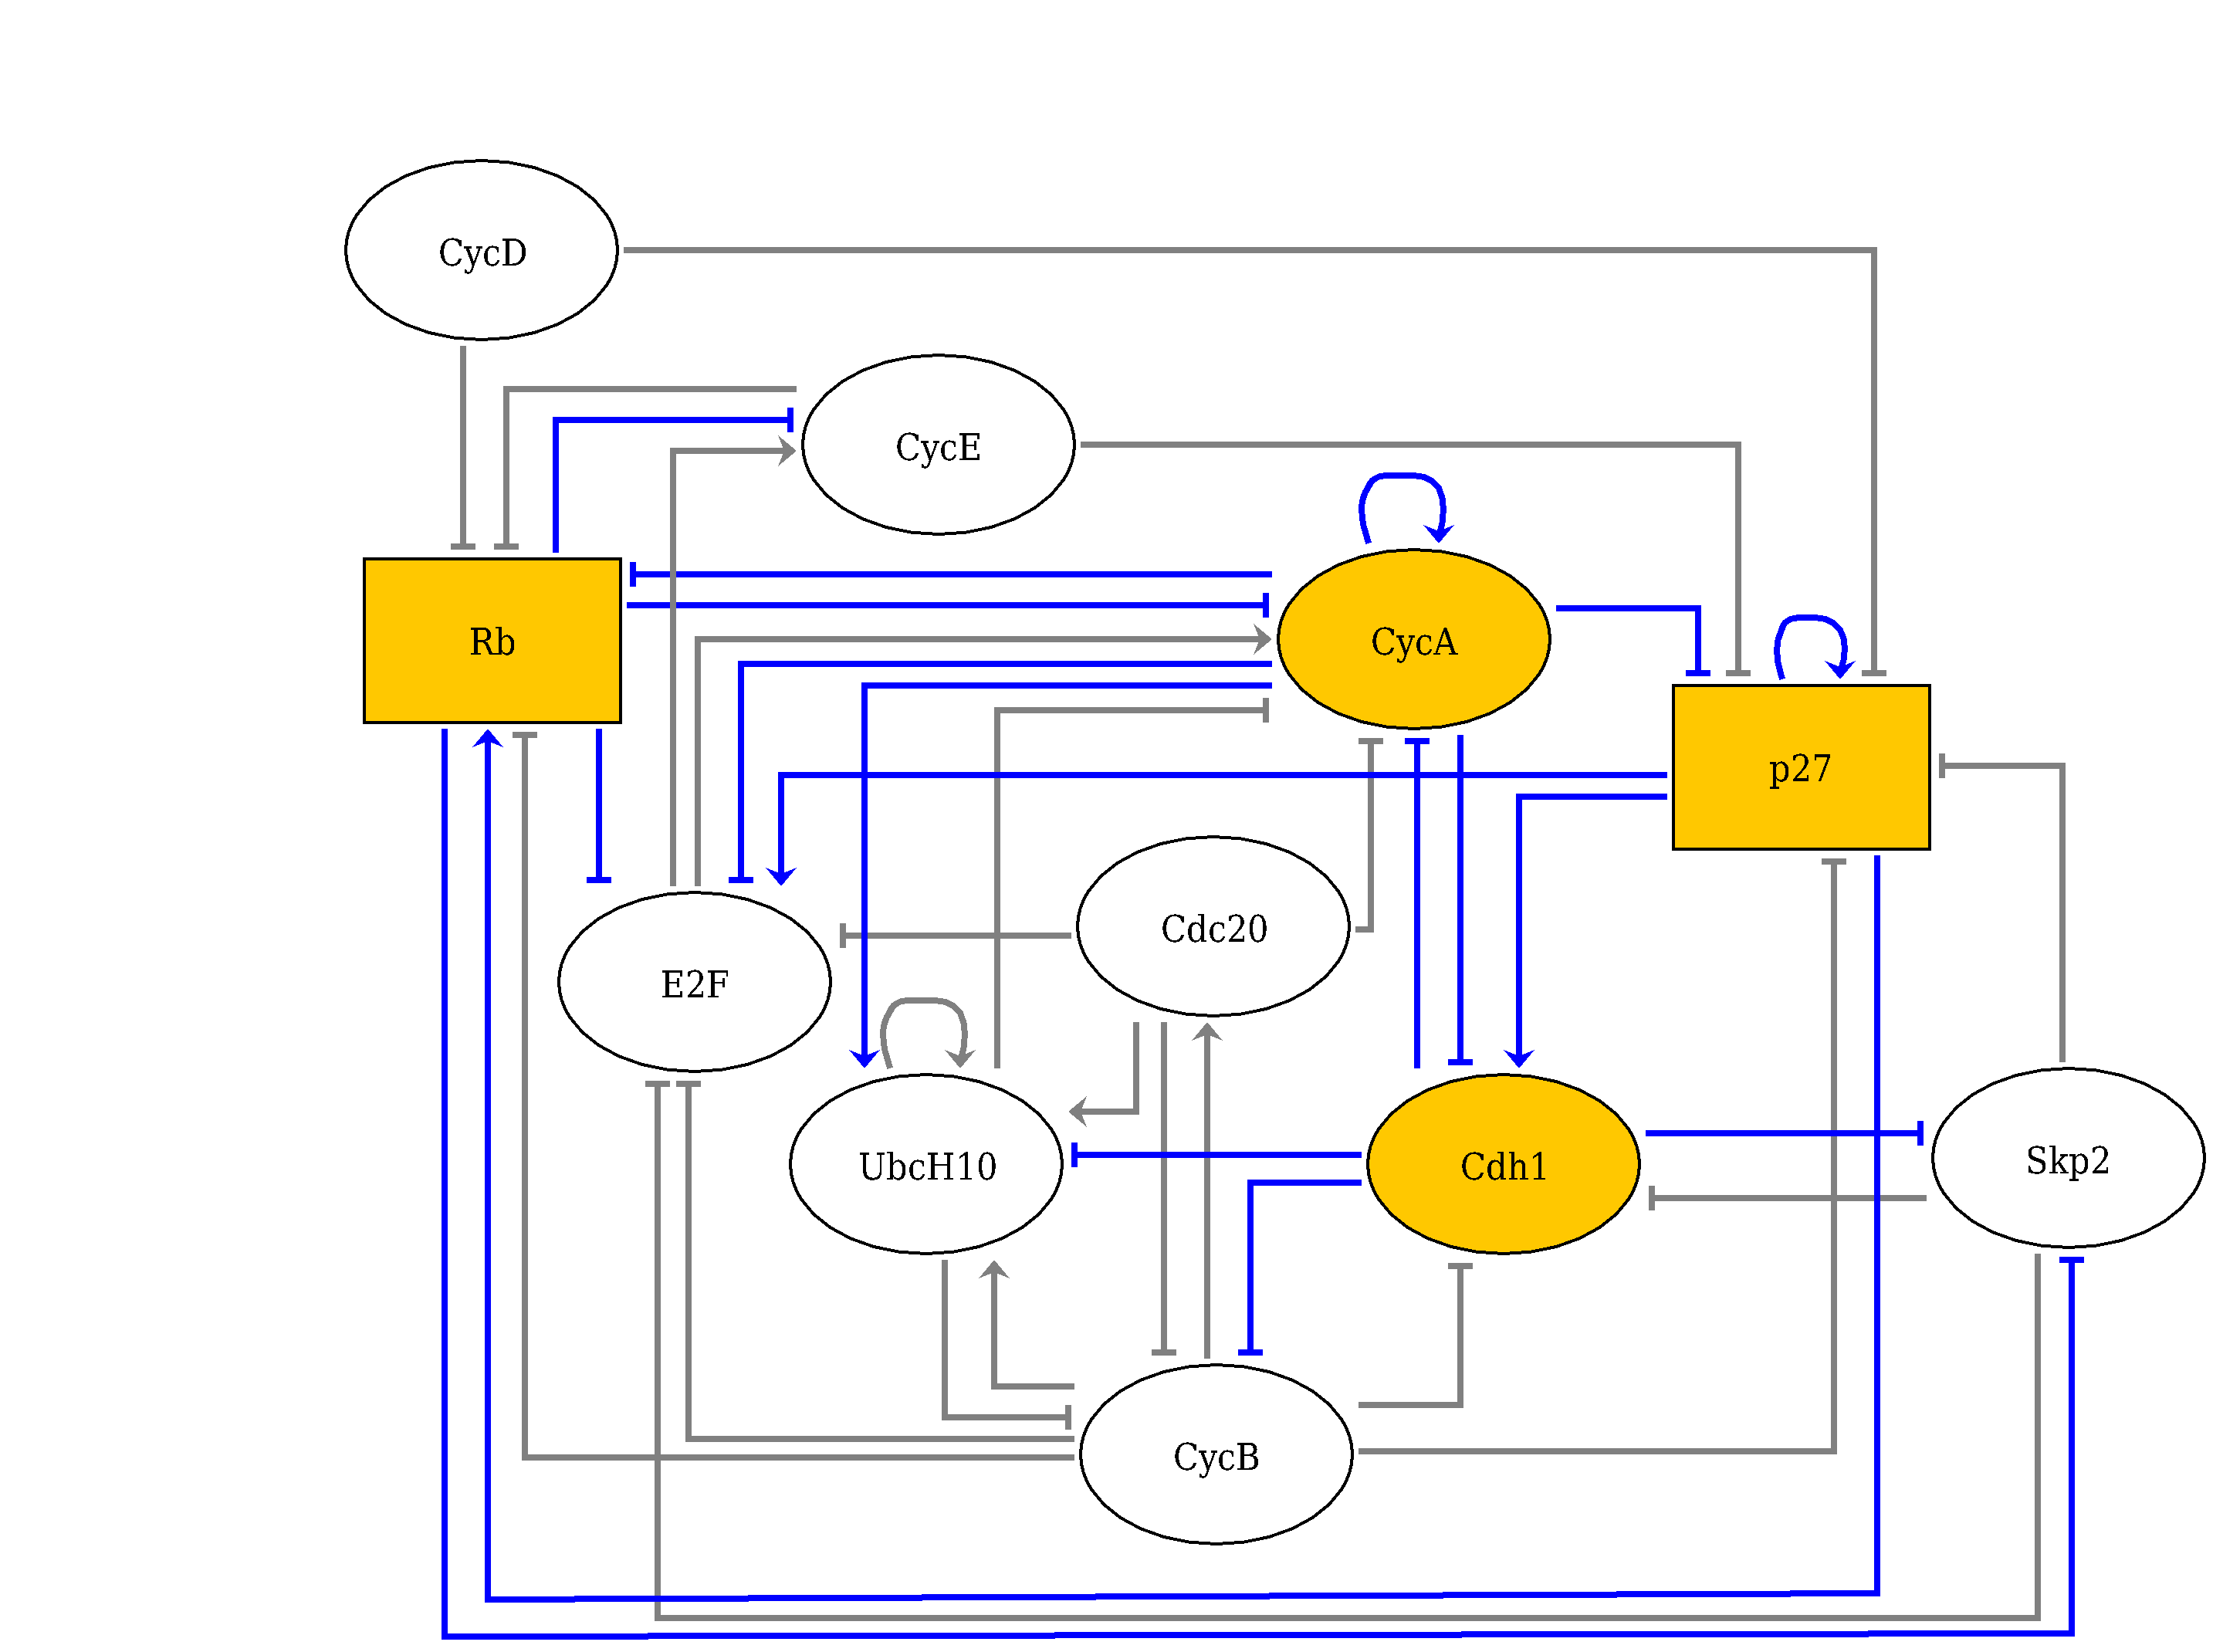

In [4]:
'''Compute stable states'''
fixpoints = biolqm.fixpoints(lqm)
tabulate(fixpoints)

'''Visualisation'''
sys.displayhook((ginsim.show(lrg, fixpoints[0])))
sys.displayhook((ginsim.show(lrg, fixpoints[1])))

2) Perturbations

We generate here the perturbations from the paper
Ectopic means: force the node to be at 1

First example shows how to do one perturbation. 
Then we automatized the process by providing the list of perturbations to test.

In [ ]:
ectopic_cyce = biolqm.perturbation(lqm,"CycE%1")
tabulate(biolqm.fixpoints(ectopic_cyce))

Below is the list of perturbations to test made suitable for BIOLQM:

In [5]:
perturbations = ["CycE%1", 
                 "p27%1", 
                 "p27% CycA%1", 
                 "p27%1 CycE%1", 
                 "p27%1 E2F%1",
                 "Rb%2", "Cdh1%0", 
                 "Rb%0", 
                 "Rb%0 E2F%1", 
                 "E2F%1 Rb%1 CycE:Rb%0 CycA:Rb%0", 
                 "CycE%0 CycA%0", 
                 "UbcH10%0", 
                 "Rb%1 E2F:Rb%0 CycE:Rb%0 CycA:Rb%0", 
                 "E2F:Rb%0 CycE:Rb%0 CycA:Rb%0", 
                 "Skp2%0", 
                 "Skp2%0 p27%0", 
                 "Skp2%1 Rb%2 E2F:Rb%0 CycE:Rb%0 CycA:Rb%0", 
                 "Rb%1 p27%0 E2F:Rb%0 CycE:Rb%0 CycA:Rb%0"]

fixpointlist = {}
for p in perturbations:
    fixpoints = biolqm.fixpoints(biolqm.perturbation(lqm, p))
    fixpointlist[p] = fixpoints
    
for k, v in fixpointlist.items():
    print(k)
    if not v:
        print('No Stable state found for: ', k)
    else:    
        sys.displayhook(tabulate(v))
    print()

CycE%1


|    |   CycD |   Rb |   E2F |   CycE |   CycA |   CycB |   p27 |   Cdc20 |   Cdh1 |   UbcH10 |   Skp2 |
|---:|-------:|-----:|------:|-------:|-------:|-------:|------:|--------:|-------:|---------:|-------:|
|  0 |      0 |    2 |     0 |      1 |      0 |      0 |     2 |       0 |      1 |        0 |      0 |
|  1 |      0 |    2 |     0 |      1 |      1 |      0 |     2 |       0 |      1 |        0 |      0 |


p27%1


|    |   CycD |   Rb |   E2F |   CycE |   CycA |   CycB |   p27 |   Cdc20 |   Cdh1 |   UbcH10 |   Skp2 |
|---:|-------:|-----:|------:|-------:|-------:|-------:|------:|--------:|-------:|---------:|-------:|
|  0 |      0 |    2 |     0 |      0 |      0 |      0 |     1 |       0 |      1 |        0 |      0 |
|  1 |      0 |    2 |     0 |      0 |      1 |      0 |     1 |       0 |      1 |        0 |      0 |
|  2 |      1 |    1 |     1 |      1 |      0 |      0 |     1 |       0 |      1 |        0 |      1 |


p27% CycA%1


|    |   CycD |   Rb |   E2F |   CycE |   CycA |   CycB |   p27 |   Cdc20 |   Cdh1 |   UbcH10 |   Skp2 |
|---:|-------:|-----:|------:|-------:|-------:|-------:|------:|--------:|-------:|---------:|-------:|
|  0 |      0 |    2 |     0 |      0 |      1 |      0 |     2 |       0 |      1 |        0 |      0 |
|  1 |      0 |    2 |     0 |      0 |      1 |      0 |     2 |       0 |      1 |        1 |      0 |


p27%1 CycE%1


|    |   CycD |   Rb |   E2F |   CycE |   CycA |   CycB |   p27 |   Cdc20 |   Cdh1 |   UbcH10 |   Skp2 |
|---:|-------:|-----:|------:|-------:|-------:|-------:|------:|--------:|-------:|---------:|-------:|
|  0 |      0 |    2 |     0 |      1 |      0 |      0 |     1 |       0 |      1 |        0 |      0 |
|  1 |      0 |    2 |     0 |      1 |      1 |      0 |     1 |       0 |      1 |        0 |      0 |
|  2 |      1 |    1 |     1 |      1 |      0 |      0 |     1 |       0 |      1 |        0 |      1 |


p27%1 E2F%1


|    |   CycD |   Rb |   E2F |   CycE |   CycA |   CycB |   p27 |   Cdc20 |   Cdh1 |   UbcH10 |   Skp2 |
|---:|-------:|-----:|------:|-------:|-------:|-------:|------:|--------:|-------:|---------:|-------:|
|  0 |      0 |    2 |     1 |      0 |      0 |      0 |     1 |       0 |      1 |        0 |      0 |
|  1 |      0 |    2 |     1 |      0 |      1 |      0 |     1 |       0 |      1 |        0 |      0 |
|  2 |      1 |    1 |     1 |      1 |      0 |      0 |     1 |       0 |      1 |        0 |      1 |


Rb%2


|    |   CycD |   Rb |   E2F |   CycE |   CycA |   CycB |   p27 |   Cdc20 |   Cdh1 |   UbcH10 |   Skp2 |
|---:|-------:|-----:|------:|-------:|-------:|-------:|------:|--------:|-------:|---------:|-------:|
|  0 |      0 |    2 |     0 |      0 |      0 |      0 |     2 |       0 |      1 |        0 |      0 |
|  1 |      0 |    2 |     0 |      0 |      1 |      0 |     2 |       0 |      1 |        0 |      0 |
|  2 |      1 |    2 |     0 |      0 |      0 |      0 |     1 |       0 |      1 |        0 |      0 |
|  3 |      1 |    2 |     0 |      0 |      1 |      0 |     1 |       0 |      1 |        0 |      0 |


Cdh1%0
No Stable state found for:  Cdh1%0

Rb%0
No Stable state found for:  Rb%0

Rb%0 E2F%1
No Stable state found for:  Rb%0 E2F%1

E2F%1 Rb%1 CycE:Rb%0 CycA:Rb%0


|    |   CycD |   Rb |   E2F |   CycE |   CycA |   CycB |   p27 |   Cdc20 |   Cdh1 |   UbcH10 |   Skp2 |
|---:|-------:|-----:|------:|-------:|-------:|-------:|------:|--------:|-------:|---------:|-------:|
|  0 |      0 |    1 |     1 |      1 |      0 |      0 |     0 |       0 |      1 |        0 |      1 |
|  1 |      0 |    1 |     1 |      1 |      0 |      0 |     2 |       0 |      1 |        0 |      1 |
|  2 |      1 |    1 |     1 |      1 |      0 |      0 |     0 |       0 |      1 |        0 |      1 |


CycE%0 CycA%0


|    |   CycD |   Rb |   E2F |   CycE |   CycA |   CycB |   p27 |   Cdc20 |   Cdh1 |   UbcH10 |   Skp2 |
|---:|-------:|-----:|------:|-------:|-------:|-------:|------:|--------:|-------:|---------:|-------:|
|  0 |      0 |    2 |     0 |      0 |      0 |      0 |     2 |       0 |      1 |        0 |      0 |
|  1 |      1 |    1 |     1 |      0 |      0 |      0 |     1 |       0 |      1 |        0 |      1 |


UbcH10%0


|    |   CycD |   Rb |   E2F |   CycE |   CycA |   CycB |   p27 |   Cdc20 |   Cdh1 |   UbcH10 |   Skp2 |
|---:|-------:|-----:|------:|-------:|-------:|-------:|------:|--------:|-------:|---------:|-------:|
|  0 |      0 |    0 |     0 |      0 |      0 |      1 |     0 |       1 |      0 |        0 |      1 |
|  1 |      0 |    0 |     0 |      0 |      1 |      1 |     0 |       1 |      0 |        0 |      1 |
|  2 |      0 |    2 |     0 |      0 |      0 |      0 |     2 |       0 |      1 |        0 |      0 |
|  3 |      0 |    2 |     0 |      0 |      1 |      0 |     2 |       0 |      1 |        0 |      0 |
|  4 |      1 |    0 |     0 |      0 |      0 |      1 |     0 |       1 |      0 |        0 |      1 |
|  5 |      1 |    0 |     0 |      0 |      1 |      1 |     0 |       1 |      0 |        0 |      1 |


Rb%1 E2F:Rb%0 CycE:Rb%0 CycA:Rb%0


|    |   CycD |   Rb |   E2F |   CycE |   CycA |   CycB |   p27 |   Cdc20 |   Cdh1 |   UbcH10 |   Skp2 |
|---:|-------:|-----:|------:|-------:|-------:|-------:|------:|--------:|-------:|---------:|-------:|
|  0 |      0 |    1 |     1 |      1 |      0 |      0 |     0 |       0 |      1 |        0 |      1 |
|  1 |      0 |    1 |     1 |      1 |      0 |      0 |     2 |       0 |      1 |        0 |      1 |
|  2 |      1 |    1 |     1 |      1 |      0 |      0 |     0 |       0 |      1 |        0 |      1 |


E2F:Rb%0 CycE:Rb%0 CycA:Rb%0


|    |   CycD |   Rb |   E2F |   CycE |   CycA |   CycB |   p27 |   Cdc20 |   Cdh1 |   UbcH10 |   Skp2 |
|---:|-------:|-----:|------:|-------:|-------:|-------:|------:|--------:|-------:|---------:|-------:|
|  0 |      0 |    2 |     0 |      0 |      0 |      0 |     2 |       0 |      1 |        0 |      0 |
|  1 |      0 |    2 |     0 |      0 |      1 |      0 |     2 |       0 |      1 |        0 |      0 |
|  2 |      1 |    1 |     1 |      1 |      0 |      0 |     0 |       0 |      1 |        0 |      1 |


Skp2%0


|    |   CycD |   Rb |   E2F |   CycE |   CycA |   CycB |   p27 |   Cdc20 |   Cdh1 |   UbcH10 |   Skp2 |
|---:|-------:|-----:|------:|-------:|-------:|-------:|------:|--------:|-------:|---------:|-------:|
|  0 |      0 |    2 |     0 |      0 |      0 |      0 |     2 |       0 |      1 |        0 |      0 |
|  1 |      0 |    2 |     0 |      0 |      1 |      0 |     2 |       0 |      1 |        0 |      0 |
|  2 |      1 |    1 |     1 |      1 |      0 |      0 |     1 |       0 |      1 |        0 |      0 |
|  3 |      1 |    1 |     1 |      1 |      1 |      0 |     1 |       0 |      1 |        0 |      0 |


Skp2%0 p27%0


|    |   CycD |   Rb |   E2F |   CycE |   CycA |   CycB |   p27 |   Cdc20 |   Cdh1 |   UbcH10 |   Skp2 |
|---:|-------:|-----:|------:|-------:|-------:|-------:|------:|--------:|-------:|---------:|-------:|
|  0 |      0 |    2 |     0 |      0 |      0 |      0 |     0 |       0 |      1 |        0 |      0 |


Skp2%1 Rb%2 E2F:Rb%0 CycE:Rb%0 CycA:Rb%0


|    |   CycD |   Rb |   E2F |   CycE |   CycA |   CycB |   p27 |   Cdc20 |   Cdh1 |   UbcH10 |   Skp2 |
|---:|-------:|-----:|------:|-------:|-------:|-------:|------:|--------:|-------:|---------:|-------:|
|  0 |      0 |    2 |     0 |      0 |      0 |      0 |     2 |       0 |      1 |        0 |      1 |
|  1 |      0 |    2 |     0 |      0 |      1 |      0 |     2 |       0 |      1 |        0 |      1 |
|  2 |      1 |    2 |     0 |      0 |      0 |      0 |     1 |       0 |      1 |        0 |      1 |


Rb%1 p27%0 E2F:Rb%0 CycE:Rb%0 CycA:Rb%0


|    |   CycD |   Rb |   E2F |   CycE |   CycA |   CycB |   p27 |   Cdc20 |   Cdh1 |   UbcH10 |   Skp2 |
|---:|-------:|-----:|------:|-------:|-------:|-------:|------:|--------:|-------:|---------:|-------:|
|  0 |      0 |    1 |     1 |      1 |      0 |      0 |     0 |       0 |      1 |        0 |      1 |
|  1 |      1 |    1 |     1 |      1 |      0 |      0 |     0 |       0 |      1 |        0 |      1 |

In [ ]:
'''List of perturbations with the nb of stable states '''
perturbstates=[]

'''List of table state values same order as perturbStates, with '''
stablestates = [] 

'''Node of nodes'''
'''nodelist = ['CycD', 'Rb', 'E2F', 'CycE', 'CycA', 'CycB', 'p27', 'Cdc20', 'Cdh1', 'UbcH10', 'Skp2', 'Proliferation', 'Arrest']'''
nodelist = ['CycD', 'Rb', 'E2F', 'CycE', 'CycA', 'CycB', 'p27', 'Cdc20', 'Cdh1', 'UbcH10', 'Skp2']

for k,v in fixpointlist.items():   
    for i in range(0,len(v)):
        listSS = []
        for key, val in v[i].items():
            listSS.append(val)
        stablestates.append(listSS)
        perturbstates.append(str(k)+' '+str(i))

In [ ]:
import seaborn as sns

In [ ]:
'''Create dataframe from the different lists above: columns = nodes, rows = perturbations'''
df = DataFrame(data=stablestates)
df = df.iloc[:, :-2] '''we remove the output nodes Proliferation and Qo_arrest'''
df.columns = nodelist
df.index = perturbstates

In [ ]:
sns.clustermap(df, metric='euclidean', cmap = 'Reds', yticklabels=True)

### Testing transient stable state reachability from a mutated initial state (with PINT):

Biological question: is it possible to reach the quiescent state from the perturbations/mutations tested in the paper?


In [12]:
perturbations = ["CycE%1", 
                 "p27%1",                 
                 "p27%1 CycA%1", 
                 "p27%1 CycE%1", 
                 "p27%1 E2F%1",
                 "Rb%2", 
                 "Cdh1%0", 
                 "Rb%0", 
                 "Rb%0 E2F%1", 
                 "CycE%0",
                 "CycE%0 CycA%0", 
                 "UbcH10%0", 
                 "Skp2%0", 
                 "Skp2%0 p27%0",
                 "p27%0"]

for perturb in perturbations:
    lock_dict = {}
    py_model = biolqm.to_pint(lqm)
    for mutation in perturb.split():
        '''Pint settings'''
        py_model.initial_state[mutation.split('%')[0]] = int(mutation.split("%")[1])
        lock_dict[mutation.split('%')[0]] = int(mutation.split("%")[1])

    print(display(tabulate(py_model.lock(lock_dict).reachable_attractors())))
    print(lock_dict, "reaches quiescent state: \t", py_model.lock(lock_dict).reachability("CycD=0"))

    print()

|    | type     |   size | sample                                                                                                                   |
|---:|:---------|-------:|:-------------------------------------------------------------------------------------------------------------------------|
|  0 | fixpoint |      1 | {'CycD': 0, 'Rb': 2, 'E2F': 0, 'CycE': 1, 'CycA': 0, 'CycB': 0, 'p27': 2, 'Cdc20': 0, 'Cdh1': 1, 'UbcH10': 0, 'Skp2': 0} |
|  1 | cyclic   |     30 | {'CycD': 0, 'Rb': 0, 'E2F': 0, 'CycE': 1, 'CycA': 0, 'CycB': 1, 'p27': 0, 'Cdc20': 0, 'Cdh1': 0, 'UbcH10': 1, 'Skp2': 1} |
|  2 | fixpoint |      1 | {'CycD': 0, 'Rb': 2, 'E2F': 0, 'CycE': 1, 'CycA': 1, 'CycB': 0, 'p27': 2, 'Cdc20': 0, 'Cdh1': 1, 'UbcH10': 0, 'Skp2': 0} |

None
{'CycE': 1} reaches quiescent state: 	 True



|    | type     |   size | sample                                                                                                                   |
|---:|:---------|-------:|:-------------------------------------------------------------------------------------------------------------------------|
|  0 | fixpoint |      1 | {'CycD': 0, 'Rb': 2, 'E2F': 0, 'CycE': 0, 'CycA': 0, 'CycB': 0, 'p27': 1, 'Cdc20': 0, 'Cdh1': 1, 'UbcH10': 0, 'Skp2': 0} |
|  1 | fixpoint |      1 | {'CycD': 0, 'Rb': 2, 'E2F': 0, 'CycE': 0, 'CycA': 1, 'CycB': 0, 'p27': 1, 'Cdc20': 0, 'Cdh1': 1, 'UbcH10': 0, 'Skp2': 0} |

None
{'p27': 1} reaches quiescent state: 	 True



|    | type     |   size | sample                                                                                                                   |
|---:|:---------|-------:|:-------------------------------------------------------------------------------------------------------------------------|
|  0 | fixpoint |      1 | {'CycD': 0, 'Rb': 2, 'E2F': 0, 'CycE': 0, 'CycA': 1, 'CycB': 0, 'p27': 1, 'Cdc20': 0, 'Cdh1': 1, 'UbcH10': 0, 'Skp2': 0} |
|  1 | cyclic   |      4 | {'CycD': 0, 'Rb': 2, 'E2F': 0, 'CycE': 0, 'CycA': 1, 'CycB': 0, 'p27': 1, 'Cdc20': 0, 'Cdh1': 0, 'UbcH10': 1, 'Skp2': 1} |
|  2 | fixpoint |      1 | {'CycD': 0, 'Rb': 2, 'E2F': 0, 'CycE': 0, 'CycA': 1, 'CycB': 0, 'p27': 1, 'Cdc20': 0, 'Cdh1': 1, 'UbcH10': 1, 'Skp2': 0} |

None
{'p27': 1, 'CycA': 1} reaches quiescent state: 	 True



|    | type     |   size | sample                                                                                                                   |
|---:|:---------|-------:|:-------------------------------------------------------------------------------------------------------------------------|
|  0 | fixpoint |      1 | {'CycD': 0, 'Rb': 2, 'E2F': 0, 'CycE': 1, 'CycA': 0, 'CycB': 0, 'p27': 1, 'Cdc20': 0, 'Cdh1': 1, 'UbcH10': 0, 'Skp2': 0} |
|  1 | fixpoint |      1 | {'CycD': 0, 'Rb': 2, 'E2F': 0, 'CycE': 1, 'CycA': 1, 'CycB': 0, 'p27': 1, 'Cdc20': 0, 'Cdh1': 1, 'UbcH10': 0, 'Skp2': 0} |

None
{'p27': 1, 'CycE': 1} reaches quiescent state: 	 True



|    | type     |   size | sample                                                                                                                   |
|---:|:---------|-------:|:-------------------------------------------------------------------------------------------------------------------------|
|  0 | fixpoint |      1 | {'CycD': 0, 'Rb': 2, 'E2F': 1, 'CycE': 0, 'CycA': 0, 'CycB': 0, 'p27': 1, 'Cdc20': 0, 'Cdh1': 1, 'UbcH10': 0, 'Skp2': 0} |
|  1 | fixpoint |      1 | {'CycD': 0, 'Rb': 2, 'E2F': 1, 'CycE': 0, 'CycA': 1, 'CycB': 0, 'p27': 1, 'Cdc20': 0, 'Cdh1': 1, 'UbcH10': 0, 'Skp2': 0} |

None
{'p27': 1, 'E2F': 1} reaches quiescent state: 	 True



|    | type     |   size | sample                                                                                                                   |
|---:|:---------|-------:|:-------------------------------------------------------------------------------------------------------------------------|
|  0 | fixpoint |      1 | {'CycD': 0, 'Rb': 2, 'E2F': 0, 'CycE': 0, 'CycA': 0, 'CycB': 0, 'p27': 2, 'Cdc20': 0, 'Cdh1': 1, 'UbcH10': 0, 'Skp2': 0} |

None
{'Rb': 2} reaches quiescent state: 	 True



|    | type   |   size | sample                                                                                                                   |
|---:|:-------|-------:|:-------------------------------------------------------------------------------------------------------------------------|
|  0 | cyclic |    288 | {'CycD': 0, 'Rb': 2, 'E2F': 0, 'CycE': 0, 'CycA': 0, 'CycB': 0, 'p27': 2, 'Cdc20': 0, 'Cdh1': 0, 'UbcH10': 1, 'Skp2': 1} |

None
{'Cdh1': 0} reaches quiescent state: 	 True



|    | type   |   size | sample                                                                                                                   |
|---:|:-------|-------:|:-------------------------------------------------------------------------------------------------------------------------|
|  0 | cyclic |    296 | {'CycD': 0, 'Rb': 0, 'E2F': 0, 'CycE': 0, 'CycA': 0, 'CycB': 0, 'p27': 2, 'Cdc20': 0, 'Cdh1': 1, 'UbcH10': 0, 'Skp2': 1} |

None
{'Rb': 0} reaches quiescent state: 	 True



|    | type   |   size | sample                                                                                                                   |
|---:|:-------|-------:|:-------------------------------------------------------------------------------------------------------------------------|
|  0 | cyclic |     15 | {'CycD': 0, 'Rb': 0, 'E2F': 1, 'CycE': 1, 'CycA': 1, 'CycB': 0, 'p27': 0, 'Cdc20': 0, 'Cdh1': 0, 'UbcH10': 0, 'Skp2': 1} |

None
{'Rb': 0, 'E2F': 1} reaches quiescent state: 	 True



|    | type     |   size | sample                                                                                                                   |
|---:|:---------|-------:|:-------------------------------------------------------------------------------------------------------------------------|
|  0 | fixpoint |      1 | {'CycD': 0, 'Rb': 2, 'E2F': 0, 'CycE': 0, 'CycA': 0, 'CycB': 0, 'p27': 2, 'Cdc20': 0, 'Cdh1': 1, 'UbcH10': 0, 'Skp2': 0} |
|  1 | fixpoint |      1 | {'CycD': 0, 'Rb': 2, 'E2F': 0, 'CycE': 0, 'CycA': 1, 'CycB': 0, 'p27': 2, 'Cdc20': 0, 'Cdh1': 1, 'UbcH10': 0, 'Skp2': 0} |

None
{'CycE': 0} reaches quiescent state: 	 True



|    | type     |   size | sample                                                                                                                   |
|---:|:---------|-------:|:-------------------------------------------------------------------------------------------------------------------------|
|  0 | fixpoint |      1 | {'CycD': 0, 'Rb': 2, 'E2F': 0, 'CycE': 0, 'CycA': 0, 'CycB': 0, 'p27': 2, 'Cdc20': 0, 'Cdh1': 1, 'UbcH10': 0, 'Skp2': 0} |

None
{'CycE': 0, 'CycA': 0} reaches quiescent state: 	 True



|    | type     |   size | sample                                                                                                                   |
|---:|:---------|-------:|:-------------------------------------------------------------------------------------------------------------------------|
|  0 | fixpoint |      1 | {'CycD': 0, 'Rb': 2, 'E2F': 0, 'CycE': 0, 'CycA': 0, 'CycB': 0, 'p27': 2, 'Cdc20': 0, 'Cdh1': 1, 'UbcH10': 0, 'Skp2': 0} |
|  1 | fixpoint |      1 | {'CycD': 0, 'Rb': 0, 'E2F': 0, 'CycE': 0, 'CycA': 0, 'CycB': 1, 'p27': 0, 'Cdc20': 1, 'Cdh1': 0, 'UbcH10': 0, 'Skp2': 1} |
|  2 | fixpoint |      1 | {'CycD': 0, 'Rb': 0, 'E2F': 0, 'CycE': 0, 'CycA': 1, 'CycB': 1, 'p27': 0, 'Cdc20': 1, 'Cdh1': 0, 'UbcH10': 0, 'Skp2': 1} |
|  3 | fixpoint |      1 | {'CycD': 0, 'Rb': 2, 'E2F': 0, 'CycE': 0, 'CycA': 1, 'CycB': 0, 'p27': 2, 'Cdc20': 0, 'Cdh1': 1, 'UbcH10': 0, 'Skp2': 0} |

None
{'UbcH10': 0} reaches quiescent state: 	 True



|    | type     |   size | sample                                                                                                                   |
|---:|:---------|-------:|:-------------------------------------------------------------------------------------------------------------------------|
|  0 | fixpoint |      1 | {'CycD': 0, 'Rb': 2, 'E2F': 0, 'CycE': 0, 'CycA': 0, 'CycB': 0, 'p27': 2, 'Cdc20': 0, 'Cdh1': 1, 'UbcH10': 0, 'Skp2': 0} |
|  1 | fixpoint |      1 | {'CycD': 0, 'Rb': 2, 'E2F': 0, 'CycE': 0, 'CycA': 1, 'CycB': 0, 'p27': 2, 'Cdc20': 0, 'Cdh1': 1, 'UbcH10': 0, 'Skp2': 0} |

None
{'Skp2': 0} reaches quiescent state: 	 True



|    | type     |   size | sample                                                                                                                   |
|---:|:---------|-------:|:-------------------------------------------------------------------------------------------------------------------------|
|  0 | fixpoint |      1 | {'CycD': 0, 'Rb': 2, 'E2F': 0, 'CycE': 0, 'CycA': 0, 'CycB': 0, 'p27': 0, 'Cdc20': 0, 'Cdh1': 1, 'UbcH10': 0, 'Skp2': 0} |

None
{'Skp2': 0, 'p27': 0} reaches quiescent state: 	 True



|    | type     |   size | sample                                                                                                                   |
|---:|:---------|-------:|:-------------------------------------------------------------------------------------------------------------------------|
|  0 | fixpoint |      1 | {'CycD': 0, 'Rb': 2, 'E2F': 0, 'CycE': 0, 'CycA': 0, 'CycB': 0, 'p27': 0, 'Cdc20': 0, 'Cdh1': 1, 'UbcH10': 0, 'Skp2': 0} |

None
{'p27': 0} reaches quiescent state: 	 True



In [13]:
mab_model = ginsim.to_maboss(lrg)
mab_model.mutate('CycA', 'ON')
mab_model.mutate('p27_b1', 'ON')
mab_model.mutate('p27_b2', 'OFF')


In [14]:
mut_results = mab_model.run()


/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2963: DtypeWarning: Columns (23,26,29,32,35,38,41,44,47,50,53,56,59,62,65,68,71,74,77,80,83,86,89,92,95,98,101,104,107,110,113,116,119,122,125,128,131,134,137,140,143,146,149,152,155,158,161,164,167,170,173,176,179,182,185,188,191,194,197,200,203,206,209,212,215,218,221,224,227,230,233,236,239,242,245,248,251,254,257,260,263,266,269,272,275,278,281,284,287,290,293,296,299,302,305,308,311,314,317,320,323,326,329,332,335,338,341,344,347,350,353,356,359,362,365,368,371,374,377,380,383,386,389,392,395,398,401,404,407,410,413,416,419,422,425,428,431,434,437,440,443,446,449,452,455,458,461,464,467,470,473,476,479,482,485,488,491,494,497,500,503,506,509,512,515,518,521,524,527,530,533,536,539,542,545,548,551,554,557,560,563,566,569,572,575,578,581,584,587,590,593,596,599,602,605,608,611,614,617,620,623,626,629,632,635,638,641,644,647,650,653,656,659,662,665,668,671,674,677,680,683,686,689,692,695,698,701,704,707,710,713,7

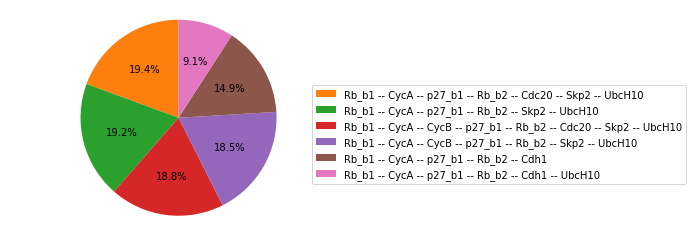

In [15]:
mut_results.plot_piechart()

### MODEL CHECKING

In [24]:
smv_cycle = """Cycle1 := (CycD=1 & Rb=0 & E2F=0 & CycE=0 & CycA=1 & CycB=0 & p27=0 & Cdc20=0 & Cdh1=0 & UbcH10=0 & Skp2=1)| (CycD=1 & Rb=1 & E2F=0 & CycE=0 & CycA=1 & CycB=0 & p27=0 & Cdc20=0 & Cdh1=0 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=0 & CycA=1 & CycB=0 & p27=0 & Cdc20=0 & Cdh1=0 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=1 & CycA=1 & CycB=0 & p27=0 & Cdc20=0 & Cdh1=0 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=1 & CycA=1 & CycB=0 & p27=0 & Cdc20=0 & Cdh1=0 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=1 & CycA=1 & CycB=0 & p27=0 & Cdc20=0 & Cdh1=0 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=1 & CycA=1 & CycB=0 & p27=0 & Cdc20=0 & Cdh1=0 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=0 & CycA=1 & CycB=1 & p27=0 & Cdc20=0 & Cdh1=0 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=0 & CycA=1 & CycB=1 & p27=0 & Cdc20=0 & Cdh1=0 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=0 & CycA=1 & CycB=1 & p27=0 & Cdc20=0 & Cdh1=0 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=0 & CycA=1 & CycB=1 & p27=0 & Cdc20=0 & Cdh1=0 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=1 & CycA=1 & CycB=1 & p27=0 & Cdc20=0 & Cdh1=0 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=1 & CycA=1 & CycB=1 & p27=0 & Cdc20=0 & Cdh1=0 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=0 & CycA=1 & CycB=0 & p27=1 & Cdc20=0 & Cdh1=0 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=0 & CycA=1 & CycB=0 & p27=1 & Cdc20=0 & Cdh1=0 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=1 & CycA=1 & CycB=1 & p27=0 & Cdc20=0 & Cdh1=0 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=1 & CycA=1 & CycB=1 & p27=0 & Cdc20=0 & Cdh1=0 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=0 & CycA=1 & CycB=0 & p27=1 & Cdc20=0 & Cdh1=0 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=0 & CycA=1 & CycB=0 & p27=1 & Cdc20=0 & Cdh1=0 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=1 & CycA=1 & CycB=0 & p27=1 & Cdc20=0 & Cdh1=0 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=1 & CycA=1 & CycB=0 & p27=1 & Cdc20=0 & Cdh1=0 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=0 & CycA=0 & CycB=0 & p27=0 & Cdc20=0 & Cdh1=1 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=1 & CycA=1 & CycB=0 & p27=1 & Cdc20=0 & Cdh1=0 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=0 & CycA=0 & CycB=0 & p27=0 & Cdc20=0 & Cdh1=1 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=1 & CycA=1 & CycB=0 & p27=1 & Cdc20=0 & Cdh1=0 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=0 & CycA=0 & CycB=0 & p27=0 & Cdc20=0 & Cdh1=1 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=0 & CycA=0 & CycB=0 & p27=0 & Cdc20=0 & Cdh1=1 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=1 & CycA=0 & CycB=0 & p27=0 & Cdc20=0 & Cdh1=1 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=1 & CycA=0 & CycB=0 & p27=0 & Cdc20=0 & Cdh1=1 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=0 & CycA=1 & CycB=1 & p27=1 & Cdc20=0 & Cdh1=0 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=1 & CycA=0 & CycB=0 & p27=0 & Cdc20=0 & Cdh1=1 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=0 & CycA=1 & CycB=1 & p27=1 & Cdc20=0 & Cdh1=0 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=1 & CycA=0 & CycB=0 & p27=0 & Cdc20=0 & Cdh1=1 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=0 & CycA=1 & CycB=0 & p27=0 & Cdc20=0 & Cdh1=1 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=0 & CycA=0 & CycB=0 & p27=0 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=0 & CycA=1 & CycB=1 & p27=1 & Cdc20=0 & Cdh1=0 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=0 & CycA=1 & CycB=0 & p27=0 & Cdc20=0 & Cdh1=1 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=0 & CycA=1 & CycB=1 & p27=1 & Cdc20=0 & Cdh1=0 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=0 & CycA=0 & CycB=0 & p27=0 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=0 & CycA=1 & CycB=0 & p27=0 & Cdc20=0 & Cdh1=1 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=0 & CycA=0 & CycB=0 & p27=0 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=1 & CycA=1 & CycB=1 & p27=1 & Cdc20=0 & Cdh1=0 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=0 & CycA=0 & CycB=0 & p27=0 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=1 & CycA=1 & CycB=1 & p27=1 & Cdc20=0 & Cdh1=0 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=1 & CycA=1 & CycB=0 & p27=0 & Cdc20=0 & Cdh1=1 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=1 & CycA=1 & CycB=1 & p27=1 & Cdc20=0 & Cdh1=0 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=1 & CycA=1 & CycB=0 & p27=0 & Cdc20=0 & Cdh1=1 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=1 & CycA=0 & CycB=0 & p27=0 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=0 & CycA=1 & CycB=1 & p27=0 & Cdc20=1 & Cdh1=0 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=1 & CycA=1 & CycB=1 & p27=1 & Cdc20=0 & Cdh1=0 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=1 & CycA=0 & CycB=0 & p27=0 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=0 & CycA=1 & CycB=1 & p27=0 & Cdc20=1 & Cdh1=0 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=1 & CycA=1 & CycB=0 & p27=0 & Cdc20=0 & Cdh1=1 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=1 & CycA=1 & CycB=0 & p27=0 & Cdc20=0 & Cdh1=1 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=0 & CycA=1 & CycB=1 & p27=0 & Cdc20=1 & Cdh1=0 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=1 & CycA=0 & CycB=0 & p27=0 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=0 & CycA=1 & CycB=1 & p27=0 & Cdc20=1 & Cdh1=0 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=1 & CycA=0 & CycB=0 & p27=0 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=0 & CycA=1 & CycB=0 & p27=0 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=0 & CycA=1 & CycB=0 & p27=0 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=1 & CycA=1 & CycB=1 & p27=0 & Cdc20=1 & Cdh1=0 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=1 & CycA=1 & CycB=1 & p27=0 & Cdc20=1 & Cdh1=0 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=0 & CycA=0 & CycB=0 & p27=1 & Cdc20=0 & Cdh1=1 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=0 & CycA=1 & CycB=0 & p27=0 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=0 & CycA=0 & CycB=0 & p27=1 & Cdc20=0 & Cdh1=1 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=0 & CycA=1 & CycB=0 & p27=0 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=1 & CycA=1 & CycB=1 & p27=0 & Cdc20=1 & Cdh1=0 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=0 & CycA=0 & CycB=0 & p27=1 & Cdc20=0 & Cdh1=1 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=1 & CycA=1 & CycB=1 & p27=0 & Cdc20=1 & Cdh1=0 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=0 & CycA=0 & CycB=0 & p27=1 & Cdc20=0 & Cdh1=1 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=0 & CycA=0 & CycB=1 & p27=0 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=1 & CycA=1 & CycB=0 & p27=0 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=1 & CycA=1 & CycB=0 & p27=0 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=0 & CycA=0 & CycB=1 & p27=0 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=1 & CycA=0 & CycB=0 & p27=1 & Cdc20=0 & Cdh1=1 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=0 & CycA=0 & CycB=1 & p27=0 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=1 & CycA=0 & CycB=0 & p27=1 & Cdc20=0 & Cdh1=1 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=1 & CycA=1 & CycB=0 & p27=0 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=1 & CycA=1 & CycB=0 & p27=0 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=0 & CycA=0 & CycB=1 & p27=0 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=1 & CycA=0 & CycB=0 & p27=1 & Cdc20=0 & Cdh1=1 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=1 & CycA=0 & CycB=0 & p27=1 & Cdc20=0 & Cdh1=1 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=1 & CycA=0 & CycB=1 & p27=0 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=1 & CycA=0 & CycB=1 & p27=0 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=0 & CycA=1 & CycB=0 & p27=1 & Cdc20=0 & Cdh1=1 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=0 & CycA=0 & CycB=0 & p27=1 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=0 & CycA=1 & CycB=0 & p27=1 & Cdc20=0 & Cdh1=1 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=0 & CycA=0 & CycB=0 & p27=1 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=1 & CycA=0 & CycB=1 & p27=0 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=0 & CycA=1 & CycB=0 & p27=1 & Cdc20=0 & Cdh1=1 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=1 & CycA=0 & CycB=1 & p27=0 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=0 & CycA=0 & CycB=0 & p27=1 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=0 & CycA=1 & CycB=0 & p27=1 & Cdc20=0 & Cdh1=1 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=0 & CycA=0 & CycB=0 & p27=1 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=0 & CycA=1 & CycB=1 & p27=0 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=0 & CycA=1 & CycB=1 & p27=0 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=1 & CycA=1 & CycB=0 & p27=1 & Cdc20=0 & Cdh1=1 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=1 & CycA=0 & CycB=0 & p27=1 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=1 & CycA=1 & CycB=0 & p27=1 & Cdc20=0 & Cdh1=1 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=0 & CycA=1 & CycB=1 & p27=1 & Cdc20=1 & Cdh1=0 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=0 & CycA=1 & CycB=1 & p27=0 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=1 & CycA=0 & CycB=0 & p27=1 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=0 & CycA=1 & CycB=1 & p27=0 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=0 & CycA=1 & CycB=1 & p27=1 & Cdc20=1 & Cdh1=0 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=1 & CycA=1 & CycB=0 & p27=1 & Cdc20=0 & Cdh1=1 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=1 & CycA=0 & CycB=0 & p27=1 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=0 & CycA=0 & CycB=0 & p27=0 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=0 & CycA=1 & CycB=1 & p27=1 & Cdc20=1 & Cdh1=0 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=1 & CycA=1 & CycB=0 & p27=1 & Cdc20=0 & Cdh1=1 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=0 & CycA=1 & CycB=1 & p27=1 & Cdc20=1 & Cdh1=0 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=0 & CycA=0 & CycB=0 & p27=0 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=1 & CycA=0 & CycB=0 & p27=1 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=1 & CycA=1 & CycB=1 & p27=0 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=1 & CycA=1 & CycB=1 & p27=0 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=0 & CycA=1 & CycB=0 & p27=1 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=0 & CycA=0 & CycB=0 & p27=0 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=0 & CycA=1 & CycB=0 & p27=1 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=1 & CycA=1 & CycB=1 & p27=1 & Cdc20=1 & Cdh1=0 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=0 & CycA=0 & CycB=0 & p27=0 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=1 & CycA=1 & CycB=1 & p27=0 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=1 & CycA=1 & CycB=1 & p27=0 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=1 & CycA=1 & CycB=1 & p27=1 & Cdc20=1 & Cdh1=0 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=0 & CycA=1 & CycB=0 & p27=1 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=0 & CycA=1 & CycB=0 & p27=1 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=1 & CycA=1 & CycB=1 & p27=1 & Cdc20=1 & Cdh1=0 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=1 & CycA=0 & CycB=0 & p27=0 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=1 & CycA=0 & CycB=0 & p27=0 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=1 & CycA=1 & CycB=1 & p27=1 & Cdc20=1 & Cdh1=0 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=0 & CycA=0 & CycB=1 & p27=1 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=1 & CycA=1 & CycB=0 & p27=1 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=0 & CycA=0 & CycB=1 & p27=1 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=1 & CycA=1 & CycB=0 & p27=1 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=1 & CycA=0 & CycB=0 & p27=0 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=1 & CycA=0 & CycB=0 & p27=0 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=0 & CycA=0 & CycB=0 & p27=0 & Cdc20=0 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=0 & CycA=0 & CycB=1 & p27=1 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=1 & CycA=1 & CycB=0 & p27=1 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=0 & CycA=0 & CycB=0 & p27=0 & Cdc20=0 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=0 & CycA=1 & CycB=0 & p27=0 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=0 & CycA=0 & CycB=1 & p27=1 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=1 & CycA=1 & CycB=0 & p27=1 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=0 & CycA=1 & CycB=0 & p27=0 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=0 & CycA=0 & CycB=0 & p27=0 & Cdc20=0 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=0 & CycA=1 & CycB=0 & p27=0 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=0 & CycA=0 & CycB=0 & p27=0 & Cdc20=0 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=1 & CycA=0 & CycB=1 & p27=1 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=0 & CycA=1 & CycB=0 & p27=0 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=1 & CycA=0 & CycB=1 & p27=1 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=1 & CycA=0 & CycB=0 & p27=0 & Cdc20=0 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=1 & CycA=0 & CycB=1 & p27=1 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=0 & CycA=0 & CycB=1 & p27=0 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=1 & CycA=0 & CycB=0 & p27=0 & Cdc20=0 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=1 & CycA=1 & CycB=0 & p27=0 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=1 & CycA=0 & CycB=1 & p27=1 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=1 & CycA=1 & CycB=0 & p27=0 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=0 & CycA=0 & CycB=1 & p27=0 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=0 & CycA=1 & CycB=1 & p27=1 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=1 & CycA=0 & CycB=0 & p27=0 & Cdc20=0 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=0 & CycA=0 & CycB=1 & p27=0 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=0 & CycA=1 & CycB=1 & p27=1 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=1 & CycA=1 & CycB=0 & p27=0 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=1 & CycA=0 & CycB=0 & p27=0 & Cdc20=0 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=1 & CycA=1 & CycB=0 & p27=0 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=0 & CycA=0 & CycB=1 & p27=0 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=0 & CycA=1 & CycB=1 & p27=1 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=0 & CycA=1 & CycB=1 & p27=1 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=1 & CycA=0 & CycB=1 & p27=0 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=1 & CycA=0 & CycB=1 & p27=0 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=0 & CycA=0 & CycB=0 & p27=1 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=1 & CycA=1 & CycB=1 & p27=1 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=0 & CycA=0 & CycB=0 & p27=1 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=1 & CycA=1 & CycB=1 & p27=1 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=1 & CycA=0 & CycB=1 & p27=0 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=1 & CycA=0 & CycB=1 & p27=0 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=0 & CycA=0 & CycB=0 & p27=1 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=0 & CycA=0 & CycB=1 & p27=0 & Cdc20=0 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=1 & CycA=1 & CycB=1 & p27=1 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=0 & CycA=0 & CycB=1 & p27=0 & Cdc20=0 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=0 & CycA=0 & CycB=0 & p27=1 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=0 & CycA=1 & CycB=1 & p27=0 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=1 & CycA=1 & CycB=1 & p27=1 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=0 & CycA=1 & CycB=1 & p27=0 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=0 & CycA=0 & CycB=1 & p27=0 & Cdc20=0 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=1 & CycA=0 & CycB=0 & p27=1 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=0 & CycA=0 & CycB=1 & p27=0 & Cdc20=0 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=0 & CycA=1 & CycB=1 & p27=0 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=1 & CycA=0 & CycB=0 & p27=1 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=0 & CycA=1 & CycB=1 & p27=0 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=1 & CycA=0 & CycB=0 & p27=1 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=1 & CycA=0 & CycB=1 & p27=0 & Cdc20=0 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=1 & CycA=0 & CycB=1 & p27=0 & Cdc20=0 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=1 & CycA=0 & CycB=0 & p27=1 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=1 & CycA=1 & CycB=1 & p27=0 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=1 & CycA=1 & CycB=1 & p27=0 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=0 & CycA=0 & CycB=0 & p27=1 & Cdc20=0 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=0 & CycA=1 & CycB=0 & p27=1 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=0 & CycA=0 & CycB=0 & p27=1 & Cdc20=0 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=1 & CycA=0 & CycB=1 & p27=0 & Cdc20=0 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=0 & CycA=1 & CycB=0 & p27=1 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=1 & CycA=0 & CycB=1 & p27=0 & Cdc20=0 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=1 & CycA=1 & CycB=1 & p27=0 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=0 & CycA=0 & CycB=0 & p27=1 & Cdc20=0 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=1 & CycA=1 & CycB=1 & p27=0 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=0 & CycA=1 & CycB=0 & p27=1 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=0 & CycA=0 & CycB=0 & p27=1 & Cdc20=0 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=0 & CycA=1 & CycB=0 & p27=1 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=1 & CycA=0 & CycB=0 & p27=1 & Cdc20=0 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=0 & CycA=0 & CycB=1 & p27=1 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=1 & CycA=1 & CycB=0 & p27=1 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=1 & CycA=0 & CycB=0 & p27=1 & Cdc20=0 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=0 & CycA=0 & CycB=1 & p27=1 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=1 & CycA=1 & CycB=0 & p27=1 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=0 & CycA=0 & CycB=0 & p27=0 & Cdc20=1 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=1 & CycA=0 & CycB=0 & p27=1 & Cdc20=0 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=1 & CycA=0 & CycB=0 & p27=1 & Cdc20=0 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=0 & CycA=0 & CycB=1 & p27=1 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=1 & CycA=1 & CycB=0 & p27=1 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=0 & CycA=0 & CycB=0 & p27=0 & Cdc20=1 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=1 & CycA=1 & CycB=0 & p27=1 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=0 & CycA=0 & CycB=1 & p27=1 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=0 & CycA=0 & CycB=0 & p27=0 & Cdc20=1 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=0 & CycA=0 & CycB=0 & p27=0 & Cdc20=1 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=1 & CycA=0 & CycB=1 & p27=1 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=1 & CycA=0 & CycB=1 & p27=1 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=1 & CycA=0 & CycB=0 & p27=0 & Cdc20=1 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=1 & CycA=0 & CycB=1 & p27=1 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=1 & CycA=0 & CycB=0 & p27=0 & Cdc20=1 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=1 & CycA=0 & CycB=1 & p27=1 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=0 & CycA=0 & CycB=1 & p27=1 & Cdc20=0 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=0 & CycA=1 & CycB=1 & p27=1 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=0 & CycA=0 & CycB=1 & p27=1 & Cdc20=0 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=1 & CycA=0 & CycB=0 & p27=0 & Cdc20=1 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=0 & CycA=1 & CycB=1 & p27=1 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=1 & CycA=0 & CycB=0 & p27=0 & Cdc20=1 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=0 & CycA=0 & CycB=1 & p27=1 & Cdc20=0 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=0 & CycA=1 & CycB=1 & p27=1 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=0 & CycA=0 & CycB=1 & p27=1 & Cdc20=0 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=0 & CycA=1 & CycB=1 & p27=1 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=1 & CycA=0 & CycB=1 & p27=1 & Cdc20=0 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=1 & CycA=1 & CycB=1 & p27=1 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=1 & CycA=0 & CycB=1 & p27=1 & Cdc20=0 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=1 & CycA=1 & CycB=1 & p27=1 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=0 & CycA=0 & CycB=1 & p27=0 & Cdc20=1 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=1 & CycA=0 & CycB=1 & p27=1 & Cdc20=0 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=1 & CycA=1 & CycB=1 & p27=1 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=1 & CycA=0 & CycB=1 & p27=1 & Cdc20=0 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=0 & CycA=0 & CycB=1 & p27=0 & Cdc20=1 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=1 & CycA=1 & CycB=1 & p27=1 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=0 & CycA=0 & CycB=1 & p27=0 & Cdc20=1 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=0 & CycA=0 & CycB=1 & p27=0 & Cdc20=1 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=1 & CycA=0 & CycB=1 & p27=0 & Cdc20=1 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=1 & CycA=0 & CycB=1 & p27=0 & Cdc20=1 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=0 & CycA=0 & CycB=0 & p27=1 & Cdc20=1 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=0 & CycA=0 & CycB=0 & p27=1 & Cdc20=1 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=1 & CycA=0 & CycB=1 & p27=0 & Cdc20=1 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=1 & CycA=0 & CycB=1 & p27=0 & Cdc20=1 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=0 & CycA=0 & CycB=0 & p27=1 & Cdc20=1 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=0 & CycA=0 & CycB=0 & p27=1 & Cdc20=1 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=1 & CycA=0 & CycB=0 & p27=1 & Cdc20=1 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=1 & CycA=0 & CycB=0 & p27=1 & Cdc20=1 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=1 & CycA=0 & CycB=0 & p27=1 & Cdc20=1 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=1 & CycA=0 & CycB=0 & p27=1 & Cdc20=1 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=0 & CycA=0 & CycB=1 & p27=1 & Cdc20=1 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=0 & CycA=0 & CycB=1 & p27=1 & Cdc20=1 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=0 & CycA=0 & CycB=1 & p27=1 & Cdc20=1 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=0 & CycA=0 & CycB=1 & p27=1 & Cdc20=1 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=1 & CycA=0 & CycB=1 & p27=1 & Cdc20=1 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=1 & CycA=0 & CycB=1 & p27=1 & Cdc20=1 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=1 & CycA=0 & CycB=1 & p27=1 & Cdc20=1 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=1 & CycA=0 & CycB=1 & p27=1 & Cdc20=1 & Cdh1=1 & UbcH10=1 & Skp2=1);"""
smv = ginsim.to_nusmv(lrg)
smv.add_instruction(smv_cycle)

In [ ]:
"""Add all the possible states in the model"""
#smv.add_instruction("""Cycle1 := (CycD=1 & Rb=0 & E2F=0 & CycE=0 & CycA=1 & CycB=0 & p27=0 & Cdc20=0 & Cdh1=0 & UbcH10=0 & Skp2=1)| (CycD=1 & Rb=1 & E2F=0 & CycE=0 & CycA=1 & CycB=0 & p27=0 & Cdc20=0 & Cdh1=0 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=0 & CycA=1 & CycB=0 & p27=0 & Cdc20=0 & Cdh1=0 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=1 & CycA=1 & CycB=0 & p27=0 & Cdc20=0 & Cdh1=0 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=1 & CycA=1 & CycB=0 & p27=0 & Cdc20=0 & Cdh1=0 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=1 & CycA=1 & CycB=0 & p27=0 & Cdc20=0 & Cdh1=0 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=1 & CycA=1 & CycB=0 & p27=0 & Cdc20=0 & Cdh1=0 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=0 & CycA=1 & CycB=1 & p27=0 & Cdc20=0 & Cdh1=0 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=0 & CycA=1 & CycB=1 & p27=0 & Cdc20=0 & Cdh1=0 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=0 & CycA=1 & CycB=1 & p27=0 & Cdc20=0 & Cdh1=0 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=0 & CycA=1 & CycB=1 & p27=0 & Cdc20=0 & Cdh1=0 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=1 & CycA=1 & CycB=1 & p27=0 & Cdc20=0 & Cdh1=0 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=1 & CycA=1 & CycB=1 & p27=0 & Cdc20=0 & Cdh1=0 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=0 & CycA=1 & CycB=0 & p27=1 & Cdc20=0 & Cdh1=0 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=0 & CycA=1 & CycB=0 & p27=1 & Cdc20=0 & Cdh1=0 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=1 & CycA=1 & CycB=1 & p27=0 & Cdc20=0 & Cdh1=0 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=1 & CycA=1 & CycB=1 & p27=0 & Cdc20=0 & Cdh1=0 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=0 & CycA=1 & CycB=0 & p27=1 & Cdc20=0 & Cdh1=0 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=0 & CycA=1 & CycB=0 & p27=1 & Cdc20=0 & Cdh1=0 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=1 & CycA=1 & CycB=0 & p27=1 & Cdc20=0 & Cdh1=0 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=1 & CycA=1 & CycB=0 & p27=1 & Cdc20=0 & Cdh1=0 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=0 & CycA=0 & CycB=0 & p27=0 & Cdc20=0 & Cdh1=1 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=1 & CycA=1 & CycB=0 & p27=1 & Cdc20=0 & Cdh1=0 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=0 & CycA=0 & CycB=0 & p27=0 & Cdc20=0 & Cdh1=1 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=1 & CycA=1 & CycB=0 & p27=1 & Cdc20=0 & Cdh1=0 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=0 & CycA=0 & CycB=0 & p27=0 & Cdc20=0 & Cdh1=1 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=0 & CycA=0 & CycB=0 & p27=0 & Cdc20=0 & Cdh1=1 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=1 & CycA=0 & CycB=0 & p27=0 & Cdc20=0 & Cdh1=1 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=1 & CycA=0 & CycB=0 & p27=0 & Cdc20=0 & Cdh1=1 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=0 & CycA=1 & CycB=1 & p27=1 & Cdc20=0 & Cdh1=0 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=1 & CycA=0 & CycB=0 & p27=0 & Cdc20=0 & Cdh1=1 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=0 & CycA=1 & CycB=1 & p27=1 & Cdc20=0 & Cdh1=0 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=1 & CycA=0 & CycB=0 & p27=0 & Cdc20=0 & Cdh1=1 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=0 & CycA=1 & CycB=0 & p27=0 & Cdc20=0 & Cdh1=1 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=0 & CycA=0 & CycB=0 & p27=0 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=0 & CycA=1 & CycB=1 & p27=1 & Cdc20=0 & Cdh1=0 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=0 & CycA=1 & CycB=0 & p27=0 & Cdc20=0 & Cdh1=1 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=0 & CycA=1 & CycB=1 & p27=1 & Cdc20=0 & Cdh1=0 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=0 & CycA=0 & CycB=0 & p27=0 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=0 & CycA=1 & CycB=0 & p27=0 & Cdc20=0 & Cdh1=1 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=0 & CycA=0 & CycB=0 & p27=0 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=1 & CycA=1 & CycB=1 & p27=1 & Cdc20=0 & Cdh1=0 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=0 & CycA=0 & CycB=0 & p27=0 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=1 & CycA=1 & CycB=1 & p27=1 & Cdc20=0 & Cdh1=0 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=1 & CycA=1 & CycB=0 & p27=0 & Cdc20=0 & Cdh1=1 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=1 & CycA=1 & CycB=1 & p27=1 & Cdc20=0 & Cdh1=0 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=1 & CycA=1 & CycB=0 & p27=0 & Cdc20=0 & Cdh1=1 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=1 & CycA=0 & CycB=0 & p27=0 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=0 & CycA=1 & CycB=1 & p27=0 & Cdc20=1 & Cdh1=0 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=1 & CycA=1 & CycB=1 & p27=1 & Cdc20=0 & Cdh1=0 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=1 & CycA=0 & CycB=0 & p27=0 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=0 & CycA=1 & CycB=1 & p27=0 & Cdc20=1 & Cdh1=0 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=1 & CycA=1 & CycB=0 & p27=0 & Cdc20=0 & Cdh1=1 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=1 & CycA=1 & CycB=0 & p27=0 & Cdc20=0 & Cdh1=1 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=0 & CycA=1 & CycB=1 & p27=0 & Cdc20=1 & Cdh1=0 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=1 & CycA=0 & CycB=0 & p27=0 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=0 & CycA=1 & CycB=1 & p27=0 & Cdc20=1 & Cdh1=0 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=1 & CycA=0 & CycB=0 & p27=0 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=0 & CycA=1 & CycB=0 & p27=0 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=0 & CycA=1 & CycB=0 & p27=0 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=1 & CycA=1 & CycB=1 & p27=0 & Cdc20=1 & Cdh1=0 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=1 & CycA=1 & CycB=1 & p27=0 & Cdc20=1 & Cdh1=0 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=0 & CycA=0 & CycB=0 & p27=1 & Cdc20=0 & Cdh1=1 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=0 & CycA=1 & CycB=0 & p27=0 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=0 & CycA=0 & CycB=0 & p27=1 & Cdc20=0 & Cdh1=1 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=0 & CycA=1 & CycB=0 & p27=0 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=1 & CycA=1 & CycB=1 & p27=0 & Cdc20=1 & Cdh1=0 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=0 & CycA=0 & CycB=0 & p27=1 & Cdc20=0 & Cdh1=1 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=1 & CycA=1 & CycB=1 & p27=0 & Cdc20=1 & Cdh1=0 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=0 & CycA=0 & CycB=0 & p27=1 & Cdc20=0 & Cdh1=1 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=0 & CycA=0 & CycB=1 & p27=0 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=1 & CycA=1 & CycB=0 & p27=0 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=1 & CycA=1 & CycB=0 & p27=0 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=0 & CycA=0 & CycB=1 & p27=0 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=1 & CycA=0 & CycB=0 & p27=1 & Cdc20=0 & Cdh1=1 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=0 & CycA=0 & CycB=1 & p27=0 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=1 & CycA=0 & CycB=0 & p27=1 & Cdc20=0 & Cdh1=1 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=1 & CycA=1 & CycB=0 & p27=0 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=1 & CycA=1 & CycB=0 & p27=0 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=0 & CycA=0 & CycB=1 & p27=0 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=1 & CycA=0 & CycB=0 & p27=1 & Cdc20=0 & Cdh1=1 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=1 & CycA=0 & CycB=0 & p27=1 & Cdc20=0 & Cdh1=1 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=1 & CycA=0 & CycB=1 & p27=0 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=1 & CycA=0 & CycB=1 & p27=0 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=0 & CycA=1 & CycB=0 & p27=1 & Cdc20=0 & Cdh1=1 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=0 & CycA=0 & CycB=0 & p27=1 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=0 & CycA=1 & CycB=0 & p27=1 & Cdc20=0 & Cdh1=1 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=0 & CycA=0 & CycB=0 & p27=1 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=1 & CycA=0 & CycB=1 & p27=0 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=0 & CycA=1 & CycB=0 & p27=1 & Cdc20=0 & Cdh1=1 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=1 & CycA=0 & CycB=1 & p27=0 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=0 & CycA=0 & CycB=0 & p27=1 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=0 & CycA=1 & CycB=0 & p27=1 & Cdc20=0 & Cdh1=1 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=0 & CycA=0 & CycB=0 & p27=1 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=0 & CycA=1 & CycB=1 & p27=0 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=0 & CycA=1 & CycB=1 & p27=0 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=1 & CycA=1 & CycB=0 & p27=1 & Cdc20=0 & Cdh1=1 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=1 & CycA=0 & CycB=0 & p27=1 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=1 & CycA=1 & CycB=0 & p27=1 & Cdc20=0 & Cdh1=1 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=0 & CycA=1 & CycB=1 & p27=1 & Cdc20=1 & Cdh1=0 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=0 & CycA=1 & CycB=1 & p27=0 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=1 & CycA=0 & CycB=0 & p27=1 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=0 & CycA=1 & CycB=1 & p27=0 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=0 & CycA=1 & CycB=1 & p27=1 & Cdc20=1 & Cdh1=0 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=1 & CycA=1 & CycB=0 & p27=1 & Cdc20=0 & Cdh1=1 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=1 & CycA=0 & CycB=0 & p27=1 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=0 & CycA=0 & CycB=0 & p27=0 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=0 & CycA=1 & CycB=1 & p27=1 & Cdc20=1 & Cdh1=0 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=1 & CycA=1 & CycB=0 & p27=1 & Cdc20=0 & Cdh1=1 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=0 & CycA=1 & CycB=1 & p27=1 & Cdc20=1 & Cdh1=0 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=0 & CycA=0 & CycB=0 & p27=0 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=1 & CycA=0 & CycB=0 & p27=1 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=1 & CycA=1 & CycB=1 & p27=0 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=1 & CycA=1 & CycB=1 & p27=0 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=0 & CycA=1 & CycB=0 & p27=1 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=0 & CycA=0 & CycB=0 & p27=0 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=0 & CycA=1 & CycB=0 & p27=1 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=1 & CycA=1 & CycB=1 & p27=1 & Cdc20=1 & Cdh1=0 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=0 & CycA=0 & CycB=0 & p27=0 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=1 & CycA=1 & CycB=1 & p27=0 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=1 & CycA=1 & CycB=1 & p27=0 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=1 & CycA=1 & CycB=1 & p27=1 & Cdc20=1 & Cdh1=0 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=0 & CycA=1 & CycB=0 & p27=1 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=0 & CycA=1 & CycB=0 & p27=1 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=1 & CycA=1 & CycB=1 & p27=1 & Cdc20=1 & Cdh1=0 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=1 & CycA=0 & CycB=0 & p27=0 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=1 & CycA=0 & CycB=0 & p27=0 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=1 & CycA=1 & CycB=1 & p27=1 & Cdc20=1 & Cdh1=0 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=0 & CycA=0 & CycB=1 & p27=1 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=1 & CycA=1 & CycB=0 & p27=1 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=0 & CycA=0 & CycB=1 & p27=1 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=1 & CycA=1 & CycB=0 & p27=1 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=1 & CycA=0 & CycB=0 & p27=0 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=1 & CycA=0 & CycB=0 & p27=0 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=0 & CycA=0 & CycB=0 & p27=0 & Cdc20=0 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=0 & CycA=0 & CycB=1 & p27=1 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=1 & CycA=1 & CycB=0 & p27=1 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=0 & CycA=0 & CycB=0 & p27=0 & Cdc20=0 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=0 & CycA=1 & CycB=0 & p27=0 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=0 & CycA=0 & CycB=1 & p27=1 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=1 & CycA=1 & CycB=0 & p27=1 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=0 & CycA=1 & CycB=0 & p27=0 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=0 & CycA=0 & CycB=0 & p27=0 & Cdc20=0 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=0 & CycA=1 & CycB=0 & p27=0 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=0 & CycA=0 & CycB=0 & p27=0 & Cdc20=0 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=1 & CycA=0 & CycB=1 & p27=1 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=0 & CycA=1 & CycB=0 & p27=0 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=1 & CycA=0 & CycB=1 & p27=1 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=1 & CycA=0 & CycB=0 & p27=0 & Cdc20=0 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=1 & CycA=0 & CycB=1 & p27=1 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=0 & CycA=0 & CycB=1 & p27=0 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=1 & CycA=0 & CycB=0 & p27=0 & Cdc20=0 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=1 & CycA=1 & CycB=0 & p27=0 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=1 & CycA=0 & CycB=1 & p27=1 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=1 & CycA=1 & CycB=0 & p27=0 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=0 & CycA=0 & CycB=1 & p27=0 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=0 & CycA=1 & CycB=1 & p27=1 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=1 & CycA=0 & CycB=0 & p27=0 & Cdc20=0 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=0 & CycA=0 & CycB=1 & p27=0 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=0 & CycA=1 & CycB=1 & p27=1 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=1 & CycA=1 & CycB=0 & p27=0 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=1 & CycA=0 & CycB=0 & p27=0 & Cdc20=0 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=1 & CycA=1 & CycB=0 & p27=0 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=0 & CycA=0 & CycB=1 & p27=0 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=0 & CycA=1 & CycB=1 & p27=1 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=0 & CycA=1 & CycB=1 & p27=1 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=1 & CycA=0 & CycB=1 & p27=0 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=1 & CycA=0 & CycB=1 & p27=0 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=0 & CycA=0 & CycB=0 & p27=1 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=1 & CycA=1 & CycB=1 & p27=1 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=0 & CycA=0 & CycB=0 & p27=1 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=1 & CycA=1 & CycB=1 & p27=1 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=1 & CycA=0 & CycB=1 & p27=0 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=1 & CycA=0 & CycB=1 & p27=0 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=0 & CycA=0 & CycB=0 & p27=1 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=0 & CycA=0 & CycB=1 & p27=0 & Cdc20=0 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=1 & CycA=1 & CycB=1 & p27=1 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=0 & CycA=0 & CycB=1 & p27=0 & Cdc20=0 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=0 & CycA=0 & CycB=0 & p27=1 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=0 & CycA=1 & CycB=1 & p27=0 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=1 & CycA=1 & CycB=1 & p27=1 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=0 & CycA=1 & CycB=1 & p27=0 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=0 & CycA=0 & CycB=1 & p27=0 & Cdc20=0 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=1 & CycA=0 & CycB=0 & p27=1 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=0 & CycA=0 & CycB=1 & p27=0 & Cdc20=0 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=0 & CycA=1 & CycB=1 & p27=0 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=1 & CycA=0 & CycB=0 & p27=1 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=0 & CycA=1 & CycB=1 & p27=0 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=1 & CycA=0 & CycB=0 & p27=1 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=1 & CycA=0 & CycB=1 & p27=0 & Cdc20=0 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=1 & CycA=0 & CycB=1 & p27=0 & Cdc20=0 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=1 & CycA=0 & CycB=0 & p27=1 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=1 & CycA=1 & CycB=1 & p27=0 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=1 & CycA=1 & CycB=1 & p27=0 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=0 & CycA=0 & CycB=0 & p27=1 & Cdc20=0 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=0 & CycA=1 & CycB=0 & p27=1 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=0 & CycA=0 & CycB=0 & p27=1 & Cdc20=0 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=1 & CycA=0 & CycB=1 & p27=0 & Cdc20=0 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=0 & CycA=1 & CycB=0 & p27=1 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=1 & CycA=0 & CycB=1 & p27=0 & Cdc20=0 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=1 & CycA=1 & CycB=1 & p27=0 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=0 & CycA=0 & CycB=0 & p27=1 & Cdc20=0 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=1 & CycA=1 & CycB=1 & p27=0 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=0 & CycA=1 & CycB=0 & p27=1 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=0 & CycA=0 & CycB=0 & p27=1 & Cdc20=0 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=0 & CycA=1 & CycB=0 & p27=1 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=1 & CycA=0 & CycB=0 & p27=1 & Cdc20=0 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=0 & CycA=0 & CycB=1 & p27=1 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=1 & CycA=1 & CycB=0 & p27=1 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=1 & CycA=0 & CycB=0 & p27=1 & Cdc20=0 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=0 & CycA=0 & CycB=1 & p27=1 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=1 & CycA=1 & CycB=0 & p27=1 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=0 & CycA=0 & CycB=0 & p27=0 & Cdc20=1 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=1 & CycA=0 & CycB=0 & p27=1 & Cdc20=0 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=1 & CycA=0 & CycB=0 & p27=1 & Cdc20=0 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=0 & CycA=0 & CycB=1 & p27=1 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=1 & CycA=1 & CycB=0 & p27=1 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=0 & CycA=0 & CycB=0 & p27=0 & Cdc20=1 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=1 & CycA=1 & CycB=0 & p27=1 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=0 & CycA=0 & CycB=1 & p27=1 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=0 & CycA=0 & CycB=0 & p27=0 & Cdc20=1 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=0 & CycA=0 & CycB=0 & p27=0 & Cdc20=1 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=1 & CycA=0 & CycB=1 & p27=1 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=1 & CycA=0 & CycB=1 & p27=1 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=1 & CycA=0 & CycB=0 & p27=0 & Cdc20=1 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=1 & CycA=0 & CycB=1 & p27=1 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=1 & CycA=0 & CycB=0 & p27=0 & Cdc20=1 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=1 & CycA=0 & CycB=1 & p27=1 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=0 & CycA=0 & CycB=1 & p27=1 & Cdc20=0 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=0 & CycA=1 & CycB=1 & p27=1 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=0 & CycA=0 & CycB=1 & p27=1 & Cdc20=0 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=1 & CycA=0 & CycB=0 & p27=0 & Cdc20=1 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=0 & CycA=1 & CycB=1 & p27=1 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=1 & CycA=0 & CycB=0 & p27=0 & Cdc20=1 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=0 & CycA=0 & CycB=1 & p27=1 & Cdc20=0 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=0 & CycA=1 & CycB=1 & p27=1 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=0 & CycA=0 & CycB=1 & p27=1 & Cdc20=0 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=0 & CycA=1 & CycB=1 & p27=1 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=1 & CycA=0 & CycB=1 & p27=1 & Cdc20=0 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=1 & CycA=1 & CycB=1 & p27=1 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=1 & CycA=0 & CycB=1 & p27=1 & Cdc20=0 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=1 & CycA=1 & CycB=1 & p27=1 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=0 & CycA=0 & CycB=1 & p27=0 & Cdc20=1 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=1 & CycA=0 & CycB=1 & p27=1 & Cdc20=0 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=1 & CycA=1 & CycB=1 & p27=1 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=1 & CycA=0 & CycB=1 & p27=1 & Cdc20=0 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=0 & CycA=0 & CycB=1 & p27=0 & Cdc20=1 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=1 & CycA=1 & CycB=1 & p27=1 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=0 & CycA=0 & CycB=1 & p27=0 & Cdc20=1 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=0 & CycA=0 & CycB=1 & p27=0 & Cdc20=1 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=1 & CycA=0 & CycB=1 & p27=0 & Cdc20=1 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=1 & CycA=0 & CycB=1 & p27=0 & Cdc20=1 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=0 & CycA=0 & CycB=0 & p27=1 & Cdc20=1 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=0 & CycA=0 & CycB=0 & p27=1 & Cdc20=1 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=1 & CycA=0 & CycB=1 & p27=0 & Cdc20=1 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=1 & CycA=0 & CycB=1 & p27=0 & Cdc20=1 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=0 & CycA=0 & CycB=0 & p27=1 & Cdc20=1 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=0 & CycA=0 & CycB=0 & p27=1 & Cdc20=1 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=1 & CycA=0 & CycB=0 & p27=1 & Cdc20=1 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=1 & CycA=0 & CycB=0 & p27=1 & Cdc20=1 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=1 & CycA=0 & CycB=0 & p27=1 & Cdc20=1 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=1 & CycA=0 & CycB=0 & p27=1 & Cdc20=1 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=0 & CycA=0 & CycB=1 & p27=1 & Cdc20=1 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=0 & CycA=0 & CycB=1 & p27=1 & Cdc20=1 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=0 & CycA=0 & CycB=1 & p27=1 & Cdc20=1 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=0 & CycA=0 & CycB=1 & p27=1 & Cdc20=1 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=1 & CycA=0 & CycB=1 & p27=1 & Cdc20=1 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=1 & CycA=0 & CycB=1 & p27=1 & Cdc20=1 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=1 & CycA=0 & CycB=1 & p27=1 & Cdc20=1 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=1 & CycA=0 & CycB=1 & p27=1 & Cdc20=1 & Cdh1=1 & UbcH10=1 & Skp2=1);""")

In [25]:
"""Test for the sequential activation of Cyclins"""
smv.add_init("CycE=0 & CycA=0 & CycB=0 & Cycle1 & Rb=1 & p27=1 & Cdh1=1 & Cdc20=0 & UbcH10=0 & Cdc20=0 & E2F=0;")
smv.add_instruction("SPEC !E[(CycE=0 & CycA=0 & CycB=0  & Cycle1) U ( CycE=1 & CycA=0 & CycB=0  & Cycle1 & E[( CycE=1 & CycA=0 & CycB=0  & Cycle1) U ( CycE=1 & CycA=1 & CycB=0  & Cycle1 & E[( CycE=1 & CycA=1 & CycB=0  & Cycle1) U ( CycE=0 & CycA=1 & CycB=0  & Cycle1 & E[( CycE=0 & CycA=1 & CycB=0  & Cycle1) U ( CycE=0 & CycA=1 & CycB=1  & Cycle1 & E[( CycE=0 & CycA=1 & CycB=1  & Cycle1) U ( CycE=0 & CycA=0 & CycB=1  & Cycle1 & E[( CycE=0 & CycA=0 & CycB=1  & Cycle1) U ( CycE=0 & CycA=0 & CycB=0  & Cycle1)])])])])])];")
smv.verify()


{'!E [ (((CycE = 0 & CycA = 0) & CycB = 0) & Cycle1) U ((((CycE = 1 & CycA = 0) & CycB = 0) & Cycle1) & E [ (((CycE = 1 & CycA = 0) & CycB = 0) & Cycle1) U ((((CycE = 1 & CycA = 1) & CycB = 0) & Cycle1) & E [ (((CycE = 1 & CycA = 1) & CycB = 0) & Cycle1) U ((((CycE = 0 & CycA = 1) & CycB = 0) & Cycle1) & E [ (((CycE = 0 & CycA = 1) & CycB = 0) & Cycle1) U ((((CycE = 0 & CycA = 1) & CycB = 1) & Cycle1) & E [ (((CycE = 0 & CycA = 1) & CycB = 1) & Cycle1) U ((((CycE = 0 & CycA = 0) & CycB = 1) & Cycle1) & E [ (((CycE = 0 & CycA = 0) & CycB = 1) & Cycle1) U (((CycE = 0 & CycA = 0) & CycB = 0) & Cycle1) ] ) ] ) ] ) ] ) ] ) ]': False}

In [26]:
"""Complete removal of CycB is required to prevent spindle checkpoint"""
smv = ginsim.to_nusmv(lrg)
smv.add_instruction(smv_cycle)
smv.add_init("CycE=0 & CycA=0 & CycB=0 & Cycle1 & Rb=1 & p27=1 & Cdh1=1 & Cdc20=0 & UbcH10=0 & Cdc20=0 & E2F=0;")
smv.add_instruction("SPEC E[(CycE=0 & CycA=0 & CycB=0  & Cycle1) U ( CycE=1 & CycA=0 & CycB=0  & Cycle1 & E[( CycE=1 & CycA=0 & CycB=0  & Cycle1) U ( CycE=1 & CycA=1 & CycB=0  & Cycle1 & E[( CycE=1 & CycA=1 & CycB=0  & Cycle1) U ( CycE=0 & CycA=1 & CycB=0  & Cycle1 & E[( CycE=0 & CycA=1 & CycB=0  & Cycle1) U ( CycE=0 & CycA=1 & CycB=1  & Cycle1 & E[( CycE=0 & CycA=1 & CycB=1  & Cycle1) U ( CycE=0 & CycA=0 & CycB=1  & Cycle1 & E[( CycE=0 & CycA=0 & CycB=1  & Cycle1) U ( CycE=1 & CycA=0 & CycB=0  & Cycle1)])])])])])];")
smv.verify()

{'E [ (((CycE = 0 & CycA = 0) & CycB = 0) & Cycle1) U ((((CycE = 1 & CycA = 0) & CycB = 0) & Cycle1) & E [ (((CycE = 1 & CycA = 0) & CycB = 0) & Cycle1) U ((((CycE = 1 & CycA = 1) & CycB = 0) & Cycle1) & E [ (((CycE = 1 & CycA = 1) & CycB = 0) & Cycle1) U ((((CycE = 0 & CycA = 1) & CycB = 0) & Cycle1) & E [ (((CycE = 0 & CycA = 1) & CycB = 0) & Cycle1) U ((((CycE = 0 & CycA = 1) & CycB = 1) & Cycle1) & E [ (((CycE = 0 & CycA = 1) & CycB = 1) & Cycle1) U ((((CycE = 0 & CycA = 0) & CycB = 1) & Cycle1) & E [ (((CycE = 0 & CycA = 0) & CycB = 1) & Cycle1) U (((CycE = 1 & CycA = 0) & CycB = 0) & Cycle1) ] ) ] ) ] ) ] ) ] ) ]': False}

In [29]:
"""Test the irrevirsability of S-phase initiation"""
"""Correct sequence starting from G1"""
smv = ginsim.to_nusmv(lrg)
smv.add_instruction(smv_cycle)
smv.add_init("CycE=0 & CycA=0 & CycB=0 & Cycle1 & Rb=1 & p27=1 & Cdh1=1 & Cdc20=0 & UbcH10=0 & Cdc20=0 & E2F=0;")
smv.add_instruction("SPEC E[(CycE=0 & CycA=0 & p27=1 & Cycle1) U ( CycE=0 & CycA=0 & p27=1 & Cycle1 & E[( CycE=0 & CycA=0 & p27=1 & Cycle1) U ( CycE=1 & CycA=0 & p27=1 & Cycle1 & E[( CycE=1 & CycA=0 & p27=1 & Cycle1) U ( CycE=1 & CycA=0 & p27=0 & Cycle1 & E[( CycE=1 & CycA=0 & p27=0 & Cycle1) U ( CycE=1 & CycA=1 & p27=0 & Cycle1 & E[( CycE=1 & CycA=1 & p27=0 & Cycle1) U ( CycE=0 & CycA=1 & p27=0 & Cycle1 & E[( CycE=1 & CycA=1 & p27=0 & Cycle1) U (CycE=0 & CycA=1 & p27=0 & Cycle1)])])])])])];")
smv.verify()

{'E [ (((CycE = 0 & CycA = 0) & p27 = 1) & Cycle1) U ((((CycE = 0 & CycA = 0) & p27 = 1) & Cycle1) & E [ (((CycE = 0 & CycA = 0) & p27 = 1) & Cycle1) U ((((CycE = 1 & CycA = 0) & p27 = 1) & Cycle1) & E [ (((CycE = 1 & CycA = 0) & p27 = 1) & Cycle1) U ((((CycE = 1 & CycA = 0) & p27 = 0) & Cycle1) & E [ (((CycE = 1 & CycA = 0) & p27 = 0) & Cycle1) U ((((CycE = 1 & CycA = 1) & p27 = 0) & Cycle1) & E [ (((CycE = 1 & CycA = 1) & p27 = 0) & Cycle1) U ((((CycE = 0 & CycA = 1) & p27 = 0) & Cycle1) & E [ (((CycE = 1 & CycA = 1) & p27 = 0) & Cycle1) U (((CycE = 0 & CycA = 1) & p27 = 0) & Cycle1) ] ) ] ) ] ) ] ) ] ) ]': True}

In [30]:
"""Incorrect sequence starting from G1 (p27 inhibited without CycE)"""
smv = ginsim.to_nusmv(lrg)
smv.add_instruction(smv_cycle)
smv.add_init("CycE=0 & CycA=0 & CycB=0 & Cycle1 & Rb=1 & p27=1 & Cdh1=1 & Cdc20=0 & UbcH10=0 & Cdc20=0 & E2F=0;")
smv.add_instruction("SPEC !E[(CycE=0 & CycA=0 & p27=1  & Cycle1) U ( CycE=0 & CycA=0 & p27=0  & Cycle1 & E[( CycE=0 & CycA=0 & p27=0  & Cycle1) U ( CycE=1 & CycA=1 & p27=0  & Cycle1 & E[( CycE=1 & CycA=1 & p27=0  & Cycle1) U ( CycE=0 & CycA=1 & p27=0  & Cycle1)])])];")
smv.verify()

{'!E [ (((CycE = 0 & CycA = 0) & p27 = 1) & Cycle1) U ((((CycE = 0 & CycA = 0) & p27 = 0) & Cycle1) & E [ (((CycE = 0 & CycA = 0) & p27 = 0) & Cycle1) U ((((CycE = 1 & CycA = 1) & p27 = 0) & Cycle1) & E [ (((CycE = 1 & CycA = 1) & p27 = 0) & Cycle1) U (((CycE = 0 & CycA = 1) & p27 = 0) & Cycle1) ] ) ] ) ]': True}

In [31]:
"""Incorrect sequence starting from G1 (CycA activated before p27 inhibition):"""
smv = ginsim.to_nusmv(lrg)
smv.add_instruction(smv_cycle)
smv.add_init("CycE=0 & CycA=0 & CycB=0 & Cycle1 & Rb=1 & p27=1 & Cdh1=1 & Cdc20=0 & UbcH10=0 & Cdc20=0 & E2F=0;")
smv.add_instruction("SPEC !E[( CycE=0 & CycA=0 & p27=1 & Cycle1) U ( CycE=1 & CycA=0 & p27=1 & Cycle1 &E[(CycE=0 & CycA=0 & p27=1 & Cycle1) U (CycE=1 & CycA=1 & p27=1 & Cycle1)])];")
smv.verify()

{'!E [ (((CycE = 0 & CycA = 0) & p27 = 1) & Cycle1) U ((((CycE = 1 & CycA = 0) & p27 = 1) & Cycle1) & E [ (((CycE = 0 & CycA = 0) & p27 = 1) & Cycle1) U (((CycE = 1 & CycA = 1) & p27 = 1) & Cycle1) ] ) ]': True}

In [32]:
"""Degradation of B cyclins by the APC/C complex is required for mitosis to take place"""
"""Correct sequence starting from G2"""
smv = ginsim.to_nusmv(lrg)
smv.add_instruction(smv_cycle)
smv.add_init("CycE=0 & CycA=1 & CycB=0 & Cycle1 & Rb=0 & p27=0 & Cdh1=0 & Cdc20=0 & UbcH10=0 & Cdc20=0 & E2F=0;")       
smv.add_instruction("SPEC !E[(CycA=1 & CycB=0 & Cdc20=0 & Cycle1) U (CycA=1 & CycB=1 & Cdc20=0 & Cycle1 &E[(CycA=1 & CycB=1 & Cdc20=0 & Cycle1) U (CycA=1 & CycB=1 & Cdc20=1 & Cycle1 & E[(CycA=1 & CycB=1 & Cdc20=1 & Cycle1) U (CycA=0 & CycB=1 & Cdc20=1 & Cycle1 & E[(CycA=0 & CycB=1 & Cdc20=1 & Cycle1) U (CycA=0 & CycB=0 & Cdc20=1 & Cycle1 & E[(CycA=0 & CycB=0 & Cdc20=1 & Cycle1) U (CycA=0 & CycB=0 & Cdc20=0 & Cycle1)])])])])];")
smv.verify()

{'!E [ (((CycA = 1 & CycB = 0) & Cdc20 = 0) & Cycle1) U ((((CycA = 1 & CycB = 1) & Cdc20 = 0) & Cycle1) & E [ (((CycA = 1 & CycB = 1) & Cdc20 = 0) & Cycle1) U ((((CycA = 1 & CycB = 1) & Cdc20 = 1) & Cycle1) & E [ (((CycA = 1 & CycB = 1) & Cdc20 = 1) & Cycle1) U ((((CycA = 0 & CycB = 1) & Cdc20 = 1) & Cycle1) & E [ (((CycA = 0 & CycB = 1) & Cdc20 = 1) & Cycle1) U ((((CycA = 0 & CycB = 0) & Cdc20 = 1) & Cycle1) & E [ (((CycA = 0 & CycB = 0) & Cdc20 = 1) & Cycle1) U (((CycA = 0 & CycB = 0) & Cdc20 = 0) & Cycle1) ] ) ] ) ] ) ] ) ]': False}

In [34]:
"""Incorrect sequence from G2(inactivation of CycB without Cdc20)"""
smv = ginsim.to_nusmv(lrg)
smv.add_instruction(smv_cycle)
smv.add_init("CycE=0 & CycA=1 & CycB=0 & Cycle1 & Rb=0 & p27=0 & Cdh1=0 & Cdc20=0 & UbcH10=0 & Cdc20=0 & E2F=0;")       
smv.add_instruction("SPEC !E[(CycA=1 & CycB=0 & Cdc20=0 & Cycle1) U (CycA=1 & CycB=1 & Cdc20=0 & Cycle1 &E[(CycA=1 & CycB=1 & Cdc20=0 & Cycle1) U (CycA=1 & CycB=1 & Cdc20=1 & Cycle1 & E[(CycA=1 & CycB=1 & Cdc20=1 & Cycle1) U (CycA=0 & CycB=1 & Cdc20=1 & Cycle1 & E[(CycA=0 & CycB=1 & Cdc20=1 & Cycle1) U (CycA=0 & CycB=1 & Cdc20=0 & Cycle1 & E[(CycA=0 & CycB=1 & Cdc20=0 & Cycle1) U (CycA=0 & CycB=0 & Cdc20=0 & Cycle1)])])])])];")
smv.verify()

{'!E [ (((CycA = 1 & CycB = 0) & Cdc20 = 0) & Cycle1) U ((((CycA = 1 & CycB = 1) & Cdc20 = 0) & Cycle1) & E [ (((CycA = 1 & CycB = 1) & Cdc20 = 0) & Cycle1) U ((((CycA = 1 & CycB = 1) & Cdc20 = 1) & Cycle1) & E [ (((CycA = 1 & CycB = 1) & Cdc20 = 1) & Cycle1) U ((((CycA = 0 & CycB = 1) & Cdc20 = 1) & Cycle1) & E [ (((CycA = 0 & CycB = 1) & Cdc20 = 1) & Cycle1) U ((((CycA = 0 & CycB = 1) & Cdc20 = 0) & Cycle1) & E [ (((CycA = 0 & CycB = 1) & Cdc20 = 0) & Cycle1) U (((CycA = 0 & CycB = 0) & Cdc20 = 0) & Cycle1) ] ) ] ) ] ) ] ) ]': True}

In [35]:
"""Incorrect sequence from G2 (inactivation of CycA without Cdc20)"""
smv = ginsim.to_nusmv(lrg)
smv.add_instruction(smv_cycle)
smv.add_init("CycE=0 & CycA=1 & CycB=0 & Cycle1 & Rb=0 & p27=0 & Cdh1=0 & Cdc20=0 & UbcH10=0 & Cdc20=0 & E2F=0;")       
smv.add_instruction("SPEC !E[(CycA=1 & CycB=0 & Cdc20=0 & Cycle1) U (CycA=1 & CycB=1 & Cdc20=0 & Cycle1 & E[(CycA=1 & CycB=1 & Cdc20=0 & Cycle1) U (CycA=0 & CycB=1 & Cdc20=0 & Cycle1 & E[(CycA=0 & CycB=1 & Cdc20=0 & Cycle1) U (CycA=0 & CycB=0 & Cdc20=0 & Cycle1)])])]")
smv.verify()

{'!E [ (((CycA = 1 & CycB = 0) & Cdc20 = 0) & Cycle1) U ((((CycA = 1 & CycB = 1) & Cdc20 = 0) & Cycle1) & E [ (((CycA = 1 & CycB = 1) & Cdc20 = 0) & Cycle1) U ((((CycA = 0 & CycB = 1) & Cdc20 = 0) & Cycle1) & E [ (((CycA = 0 & CycB = 1) & Cdc20 = 0) & Cycle1) U (((CycA = 0 & CycB = 0) & Cdc20 = 0) & Cycle1) ] ) ] ) ]': True}

### PINT AND MABOSS: find mutations not leading to a SS 

In [6]:
wt_sim = biolqm.to_maboss(lqm)

In [7]:
wt_sim.network.set_istate("CycD", [0.5,0.5])

In [8]:
wt_sim.update_parameters(max_time=50)

In [9]:
wt_res = wt_sim.run()

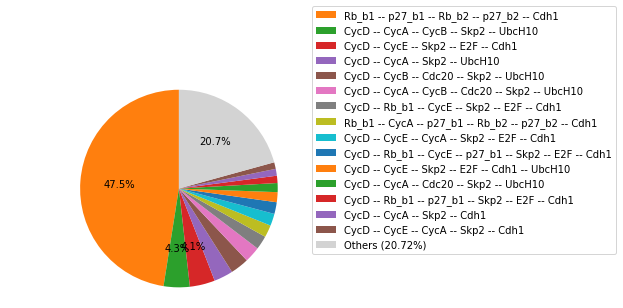

In [10]:
wt_res.plot_piechart()

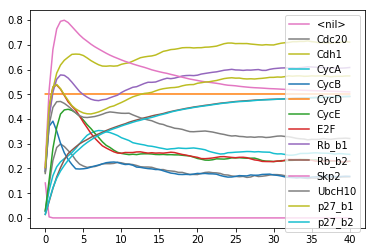

In [11]:
wt_res.plot_node_trajectory(until=40)

In [16]:
m = biolqm.to_pint(lqm)

In [20]:
m.initial_state["CycD"] = 0

In [21]:
mutants = m.oneshot_mutations_for_cut("Rb=2, p27=1, Cdh1=1")
mutants

This computation is an *under-approximation*: returned mutations are all valid, but they may be non-minimal, and some solutions may be missed.

Limiting solutions to mutations of at most 5 automata. Use `maxsize` argument to change.

[{'CycD': 1},
 {'CycE': 1, 'Skp2': 1},
 {'CycA': 1, 'Skp2': 1},
 {'CycB': 1, 'Skp2': 1},
 {'CycE': 1, 'CycA': 1, 'CycB': 1}]

In [22]:
mutants_comb = [combinations(m.items(),2) for m in mutants if len(m) >= 2]
candidates = reduce(set.union, mutants_comb, set())
candidates

{(('CycA', 1), ('CycB', 1)),
 (('CycA', 1), ('Skp2', 1)),
 (('CycB', 1), ('Skp2', 1)),
 (('CycE', 1), ('CycA', 1)),
 (('CycE', 1), ('CycB', 1)),
 (('CycE', 1), ('Skp2', 1))}

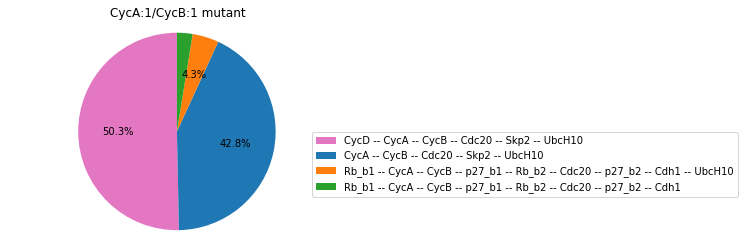

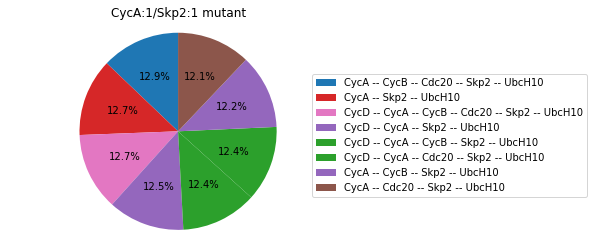

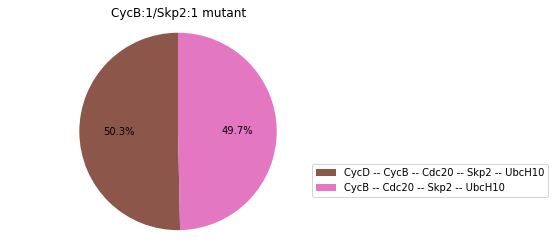

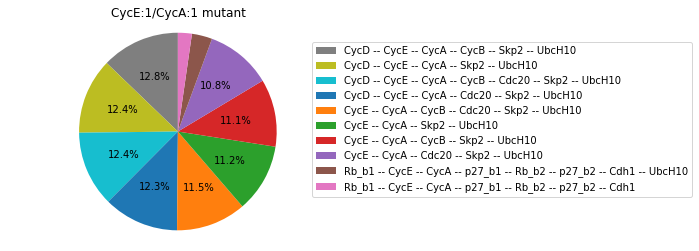

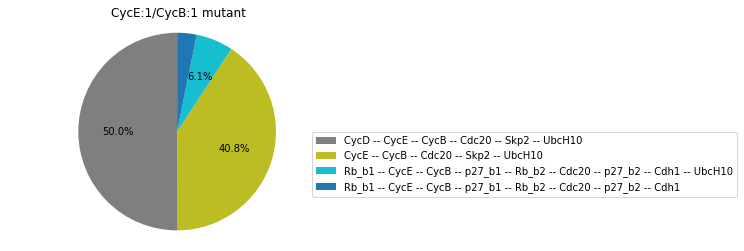

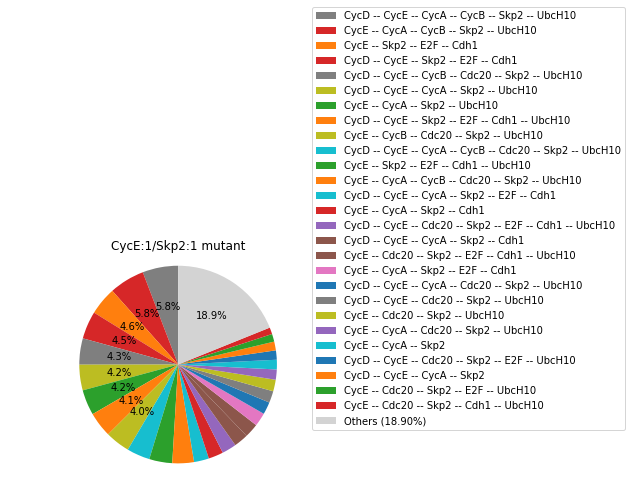

In [23]:
for mutant in sorted(candidates):
    mut_sim = wt_sim.copy()
    for (node, value) in mutant:
        mut_sim.mutate(node, "ON" if value else "OFF")
    mut_res = mut_sim.run()
    mut_res.plot_piechart(embed_labels=False, autopct=4)
    mutant_name = "/".join(["%s:%s"%m for m in mutant])
    plt.title("%s mutant" %mutant_name)
    